In [132]:
# imports
import csv
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import seaborn as sns
import pandas as pd
import os
from prettytable import PrettyTable

In [133]:
def containsMarket(column, market=""):
    if market:
        return market in column
    return "-am" in column or "-sm" in column

def get_longform(df, key):
    frames_col = get_frames_col(df)
    cols = extract_cols(df, key)
    cols.insert(0,frames_col)
    # first create wideform
    df_wideform = df[cols].copy()
    # reshape dataframe into longform
    lf = df_wideform.melt(id_vars=[frames_col], var_name="setting", value_name=key)
    lf.rename(columns={frames_col:'frames'}, inplace=True)
    return lf

def extract_cols(df, key):
    result_cols = []
    for col in df.columns:
        if key in col:
            if not "reward" in col:
                # always safe values
                result_cols.append(col)
            elif "reward_summary" in col:
                result_cols.append(col)
                # if "agent_0" in col:
                #     # always safe agent 0 values
                #     result_cols.append(col)
                # if "mixed" in col or containsMarket(col):
                #     if not "agent_0" in col:
                #         # always add mixed or market values for each agent since they differ from each other
                #         result_cols.append(col)
    return result_cols

def get_frames_col(df):
    for col in df.columns:
        if "frames" in col:
            # since frames don't differ between settings, but i.e. three agents probably 
            # needs more frames pick the column that has the most values
            # (for example check if the value of the last index is not NaN)
            last_value = df[col].iloc[-1]
            if not np.isnan(last_value):
                return col

In [134]:
# read all storage folders to extract training info, i.e. markets and save it to envs
try:
    training_folders = os.listdir('.') 
except(FileNotFoundError):
    training_folders = []

# while iterating create a wideform dataframe of all csv files
df_settings_dict = {}

for folder in training_folders:
    if "plot_results" in folder or "dqn_comparisons" in folder:
        continue

    # read csv file (if it exists)
    try:
        df_settings_dict[folder] = pd.read_csv('./'+folder+'/log.csv')
    except:
        continue

    # add setting to the df columns
    df_settings_dict[folder].columns = [folder + "_" + str(col) for col in df_settings_dict[folder].columns]
    
# join all dataframes (one per setting)
all_data_df = pd.concat([df for df in df_settings_dict.values()], axis=1)

In [135]:
keys = ["reward_summary", "mean_grid_coloration_percentage", "mean_num_reset_fields", "fully_colored", "mean_num_frames_per_episode", "mean_trades"]
base_settings = ["dqn", "ppo", "mixed", "mixed-competitive", "percentage", "rooms","rooms-mixed","rooms-percentage","rooms-mixed-competitive"]


# generate normalized rewards and longforms
lf_settings_dicts = {}
lf_comparison_settings_dict = {}
df = pd.concat([df for setting, df in df_settings_dict.items() if "rooms" not in setting], axis=1)

# settings = []
# min_value = None
# max_value = None

# for col in df.columns:
#     if "mean_reward" in col:
#         if min_value is None or min_value >= df[col].min():
#             min_value = df[col].min()
#         if max_value is None or max_value <= df[col].max():
#             max_value = df[col].max()
#         if "agent_0" in col:
#             settings.append(col.split("_mean_reward")[0])
# print("min: " + str(min_value))
# print("max: " + str(max_value))
# print(settings)
for setting in df_settings_dict.keys():
    # if "rooms" in setting:
    #     continue
    settings_df = df_settings_dict[setting].copy()
    reward_cols = [col for col in settings_df.columns if setting+"_mean_reward" in col]
    new_col = setting+"_reward_summary"
    settings_df[new_col] = settings_df[reward_cols].sum(axis='columns')
    # normalize values here
    col_min = settings_df[new_col].min()
    col_max = settings_df[new_col].max()
    settings_df[new_col] = (settings_df[new_col]-col_min)/(col_max-col_min)
    for key in keys:
        # create longforms
        index = setting+ "_" + key
        lf_settings_dicts[index] = get_longform(settings_df, key)

        if containsMarket(setting):
            #to be compared with base setting!
            base_setting = setting.split("-am")[0] if "-am" in setting else setting.split("-sm")[0]
            base_market = base_setting + "-am" if "-am" in setting else base_setting + "-sm"
            market_index = base_market + "_" + key
            if market_index not in lf_comparison_settings_dict:
                if "reward" in key:
                    # in that case calculate and add the base data first to compare it with later on!
                    base_df = df_settings_dict[base_setting].copy()
                    reward_cols = [col for col in base_df.columns if base_setting+"_mean_reward" in col]
                    new_col = base_setting+"_reward_summary"
                    base_df[new_col] = base_df[reward_cols].sum(axis='columns')
                    
                    base_col_min = base_df[new_col].min()
                    base_col_max = base_df[new_col].max()
                    # normalize values here
                    base_df[new_col] = (base_df[new_col]-base_col_min)/(base_col_max-base_col_min)
                else: 
                    base_df = df_settings_dict[base_setting]
                lf_base = get_longform(base_df, key)
                lf_comparison_settings_dict[market_index] = lf_base
            lf_comparison_settings_dict[market_index] = lf_comparison_settings_dict[market_index].append(lf_settings_dicts[index], ignore_index=True)
        elif "-dr" in setting:
            base_setting = setting.split("-dr")[0]
            if index not in lf_comparison_settings_dict:
                if "reward" in key:
                    base_df = df_settings_dict[base_setting].copy()
                    reward_cols = [col for col in base_df.columns if base_setting+"_mean_reward" in col]
                    new_col = base_setting+"_reward_summary"
                    base_df[new_col] = base_df[reward_cols].sum(axis='columns')
                    base_col_min = base_df[new_col].min()
                    base_col_max = base_df[new_col].max()
                    # normalize values here
                    base_df[new_col] = (base_df[new_col]-base_col_min)/(base_col_max-base_col_min)
                else:
                    base_df = df_settings_dict[base_setting]
                lf_base = get_longform(base_df, key)
                lf_comparison_settings_dict[index] = lf_base
            lf_comparison_settings_dict[index] = lf_comparison_settings_dict[index].append(lf_settings_dicts[index], ignore_index=True)
        if "1-dqn" in setting or "1-ppo" in setting:
            # those settings do not (/ should not) have markets
            lf_comparison_settings_dict[index] = lf_settings_dicts[index]

print([k for k in lf_comparison_settings_dict.keys() if "summary" in k])

['1-dqn_reward_summary', '1-ppo_reward_summary', '2-dqn-am_reward_summary', '2-dqn-dr_reward_summary', '2-dqn-mixed-am_reward_summary', '2-ppo-am_reward_summary', '2-ppo-dr_reward_summary', '2-ppo-mixed-am_reward_summary', '2-ppo-mixed-competitive-am_reward_summary', '2-ppo-mixed-competitive-sm_reward_summary', '2-ppo-mixed-sm_reward_summary', '2-ppo-sm_reward_summary']


In [136]:
durations = []
for col in all_data_df.columns:
    if ("-ppo" in col or "-dqn" in col) and "duration_in_seconds" in col:
        index = all_data_df[col].last_valid_index()
        duration = all_data_df.at[index,col]
        if duration >= 6000: # higher than 1 1/2 hours
            print(col + " with duration " + str(duration) + " in hours: " + str((duration/60)/60))
        durations.append(all_data_df.at[index,col])

print("overall duration in hours " + str((sum(durations)/60)/60)) #prints duration of all settings in hours

2-dqn_duration_in_seconds with duration 9186 in hours: 2.5516666666666667
2-dqn-am_duration_in_seconds with duration 9502 in hours: 2.6394444444444445
2-dqn-am-goal_duration_in_seconds with duration 9363 in hours: 2.6008333333333336
2-dqn-am-goal-no-reset-no-debt_duration_in_seconds with duration 9348 in hours: 2.5966666666666667
2-dqn-am-no-debt_duration_in_seconds with duration 9282 in hours: 2.578333333333333
2-dqn-am-no-reset_duration_in_seconds with duration 9502 in hours: 2.6394444444444445
2-dqn-dr_duration_in_seconds with duration 10817 in hours: 3.004722222222222
2-dqn-mixed_duration_in_seconds with duration 9384 in hours: 2.606666666666667
2-dqn-mixed-am_duration_in_seconds with duration 9226 in hours: 2.562777777777778
2-dqn-mixed-am-no-debt_duration_in_seconds with duration 9422 in hours: 2.6172222222222223
2-dqn-mixed-am-no-reset_duration_in_seconds with duration 9185 in hours: 2.551388888888889
2-dqn-mixed-competitive_duration_in_seconds with duration 9393 in hours: 2.609

In [138]:
# sns.set_theme()
# max_col = 2
# max_row = 3
# col = 0
# row = 0
# for setting in lf_comparison_settings_dict.keys():
#     if row >= max_row or (row == 0 and col == 0): 
#         row = 0
#         # create new plot
#         f, axes = plt.subplots(nrows=max_row, ncols=max_col, figsize=(20, 16)) 
#         plt.subplots_adjust(hspace=0.3)
#     title = " ".join(setting.replace("_", "-").split("-"))
#     key = [k for k in keys if k in setting][0]
#     y_label = " ".join(key.split("_"))
#     if "reward" in key:
#         g = sns.barplot(
#             data=lf_comparison_settings_dict[setting].iloc[::6, :], 
#             x="frames", y=key, hue="setting", palette="pastel", ax=axes[row, col], dodge=False
#         )
#         # g.set_xticklabels(g.get_xticklabels(), rotation=40, ha="right")
#         n = 4  # Keeps every 7th label
#         [l.set_visible(False) for (i,l) in enumerate(g.xaxis.get_ticklabels()) if i % n != 0]

#     else:
#         g = sns.lineplot(data=lf_comparison_settings_dict[setting], legend="brief", x="frames", y=key, hue="setting", style="setting", ax=axes[row, col], linewidth=2, palette="pastel") #"magma" | "viridis"
#         # g.set(ylabel=y_label, title=title)

#     #beatify plot legend labels
#     _, labels = g.get_legend_handles_labels()
#     for index, label in enumerate(labels):
#         if containsMarket(label):
#             base = label.split("-am")[0] if "-am" in setting else setting.split("-sm")[0]
#             new_label = label.split(base)[1]
#             new_label = new_label.split(key)[0]
#         elif "-dr" in label:
#             new_label = "difference reward" #label.split("-dr")[0]+"-dr"
#         else:
#             new_label = label.split(key)[0] #" ".join(label.split("_")).replace(title+" ", "")
#         new_label = " ".join(new_label.split("_"))
#         new_label = " ".join(new_label.split("-"))
#         labels[index] = new_label.strip()
#     g.legend(handles=g.legend_.legendHandles,labels=labels)
    
#     axes[row, col].set_ylabel(y_label)
#     axes[row, col].set_title(title, fontsize = 15.0)

#     col += 1
#     if col == max_col:
#         row += 1
#         col = 0

#     f.tight_layout()

In [139]:
print(len(lf_comparison_settings_dict.keys())/len(keys))
detailed_plots = np.array_split(list(lf_comparison_settings_dict.keys()), len(lf_comparison_settings_dict.keys())/len(keys))


12.0


C:\Users\Zarah\.virtualenvs\Coloring_with_CAP-xNNGJax5\lib\site-packages\IPython\core\pylabtools.py:137: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


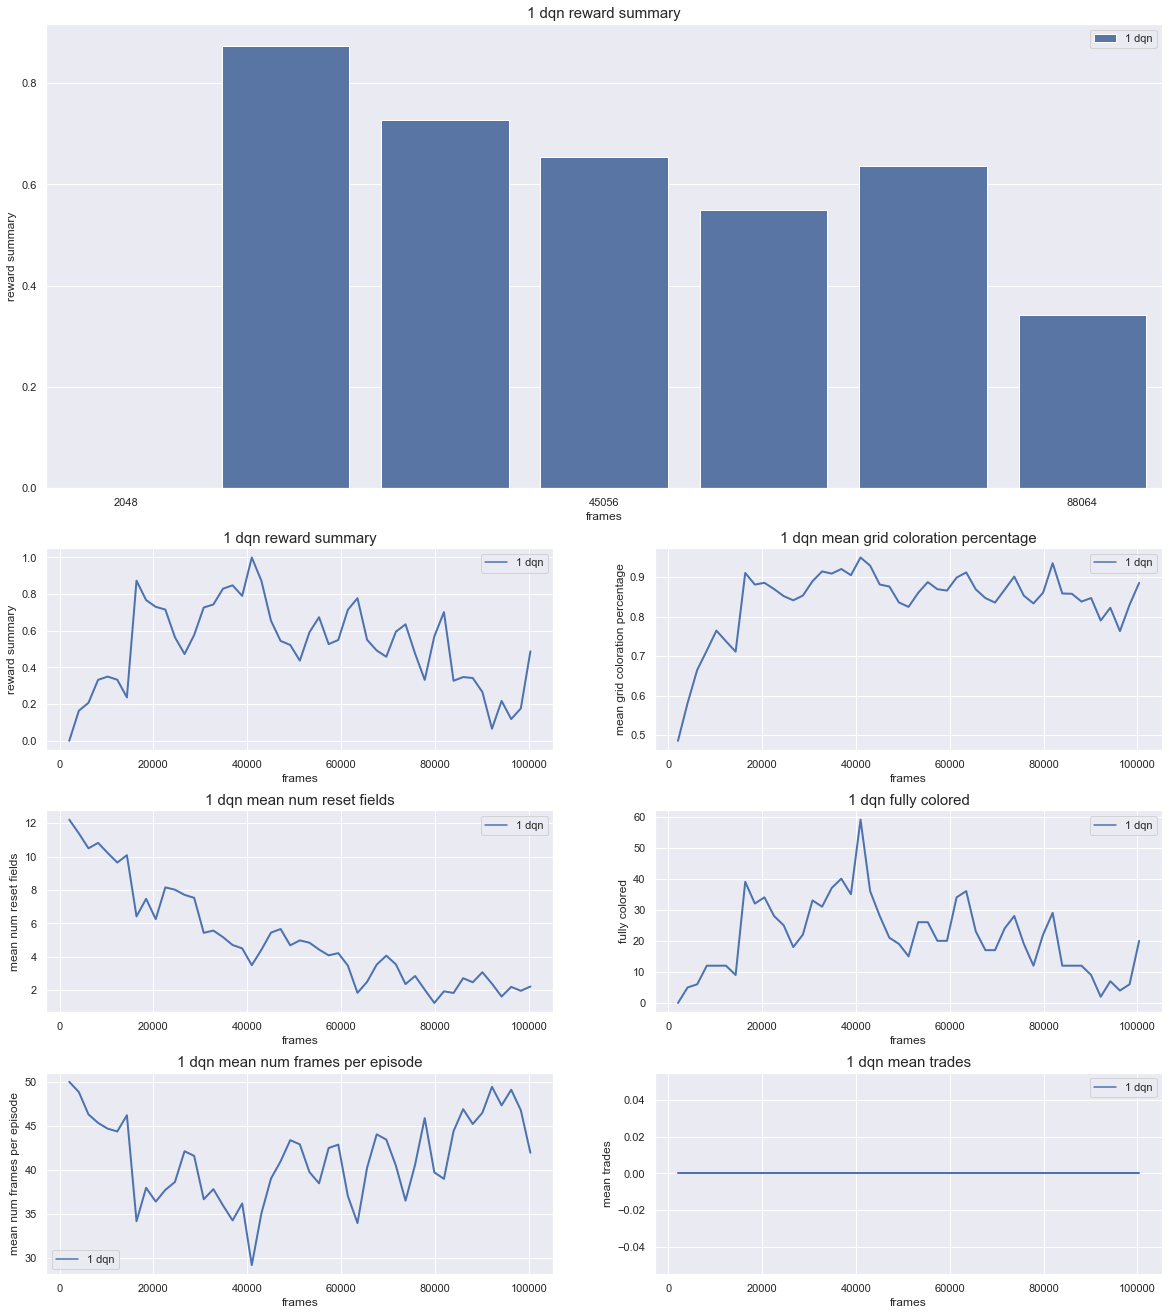

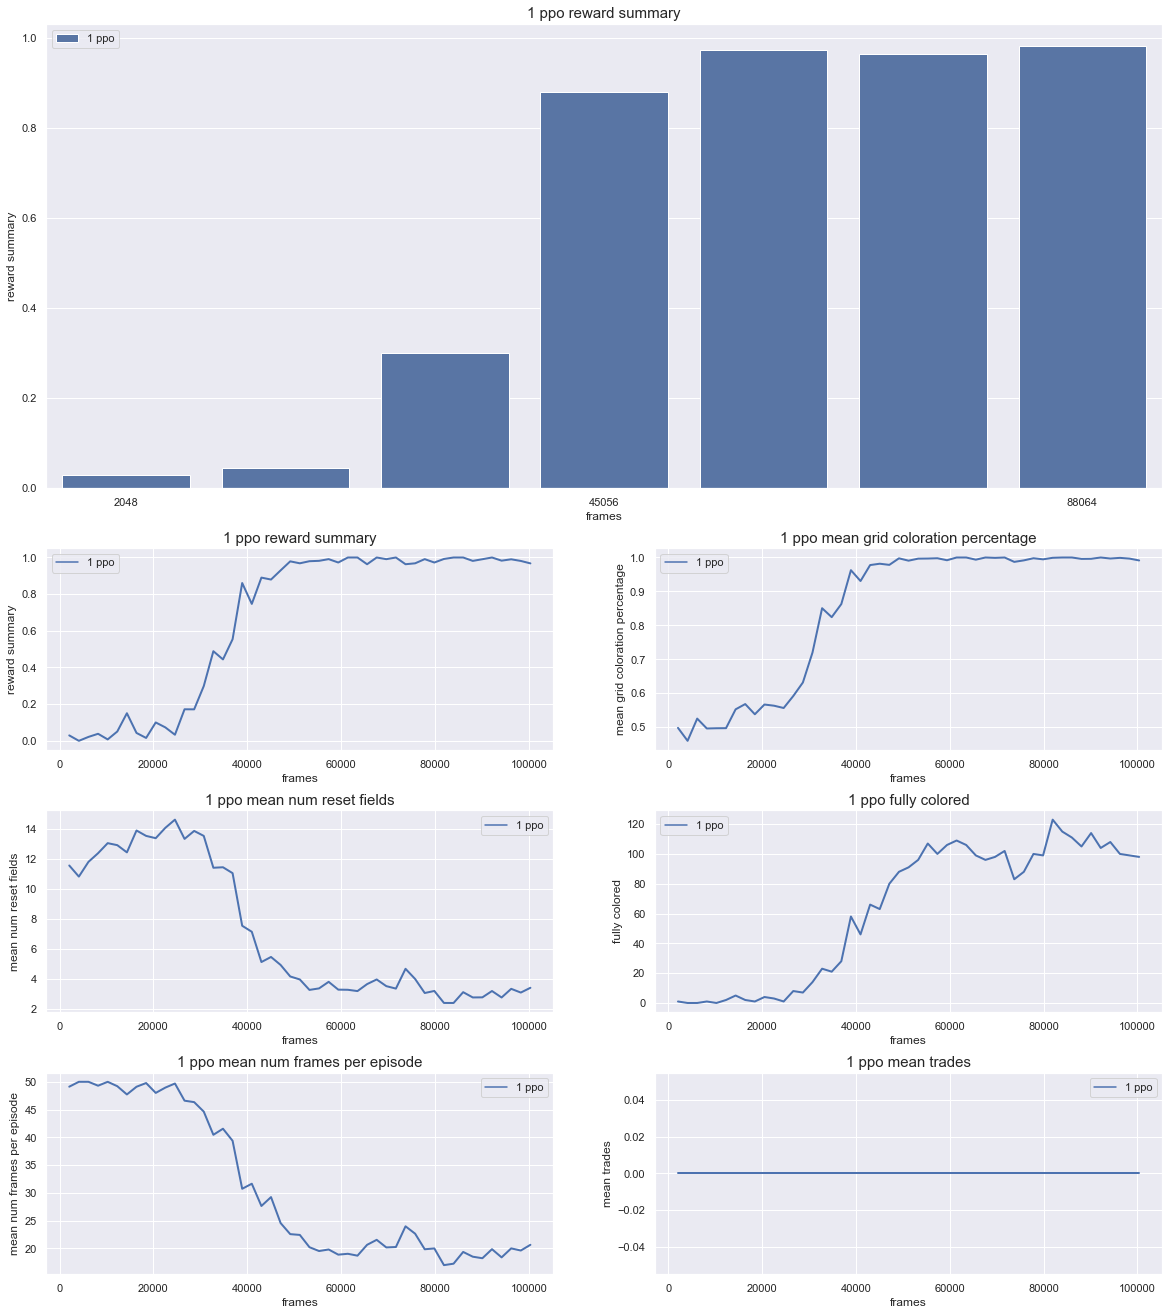

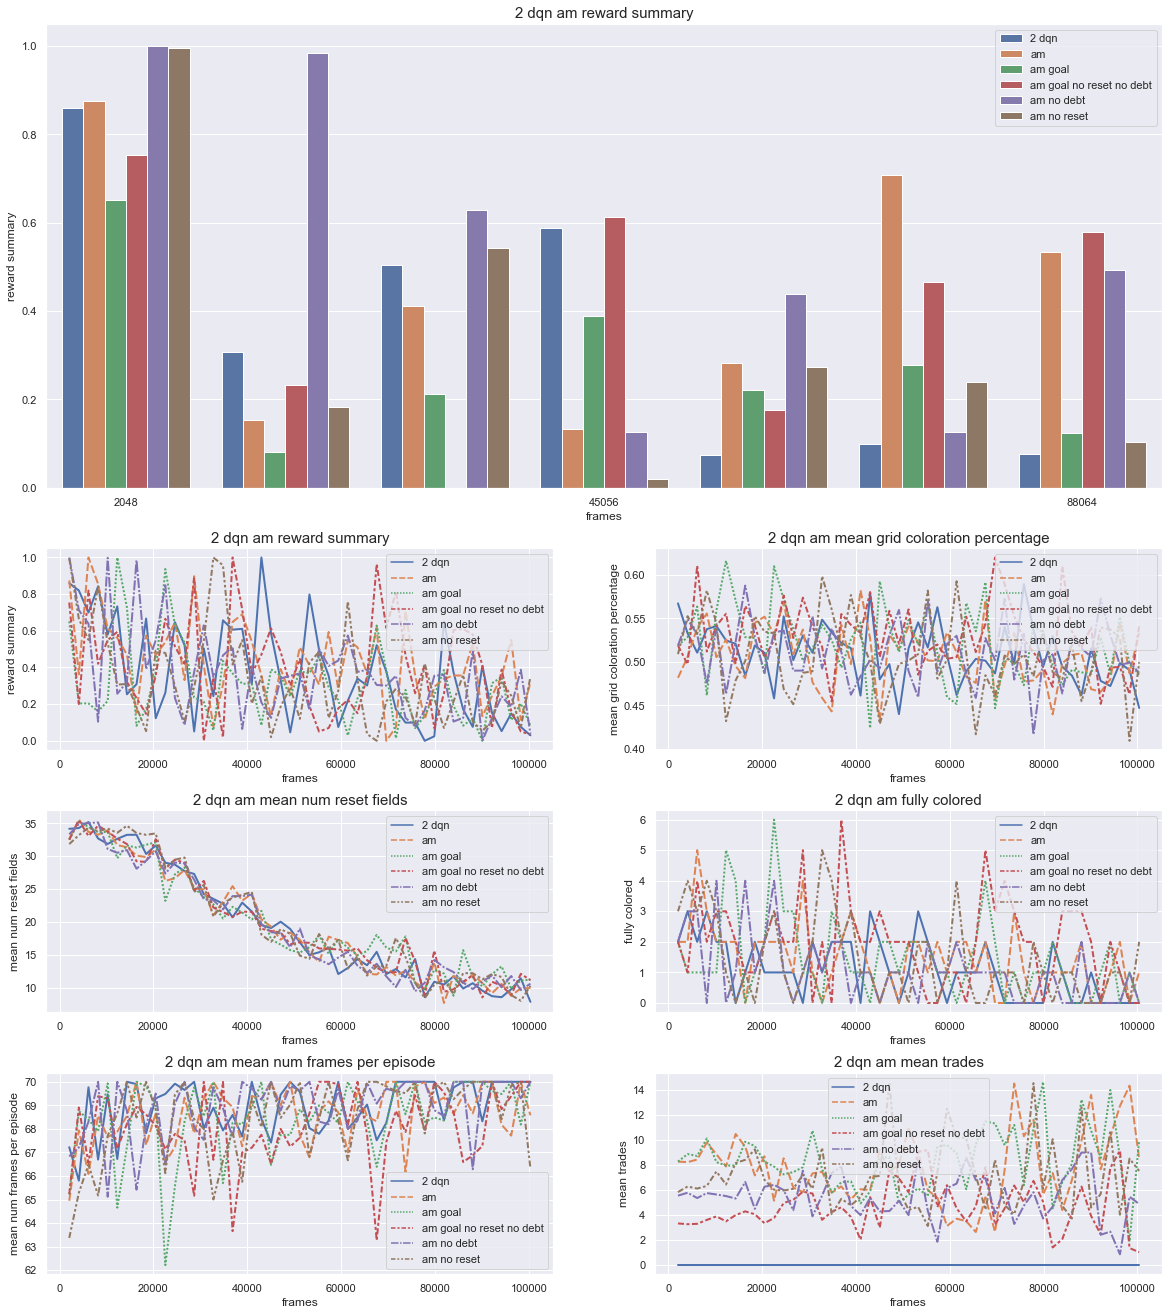

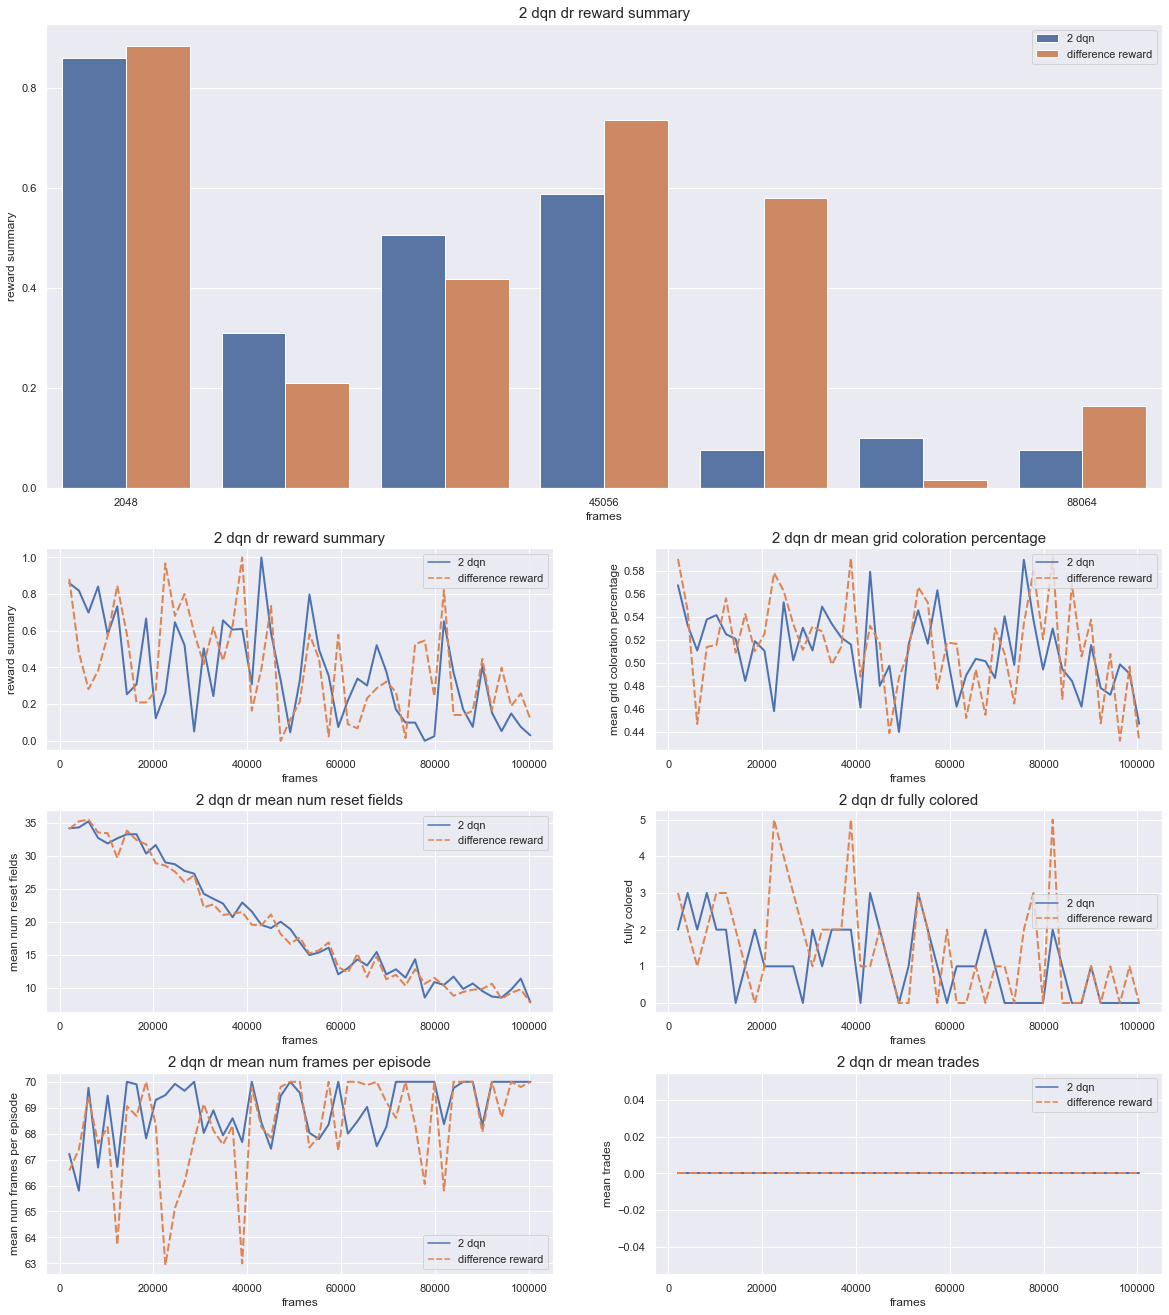

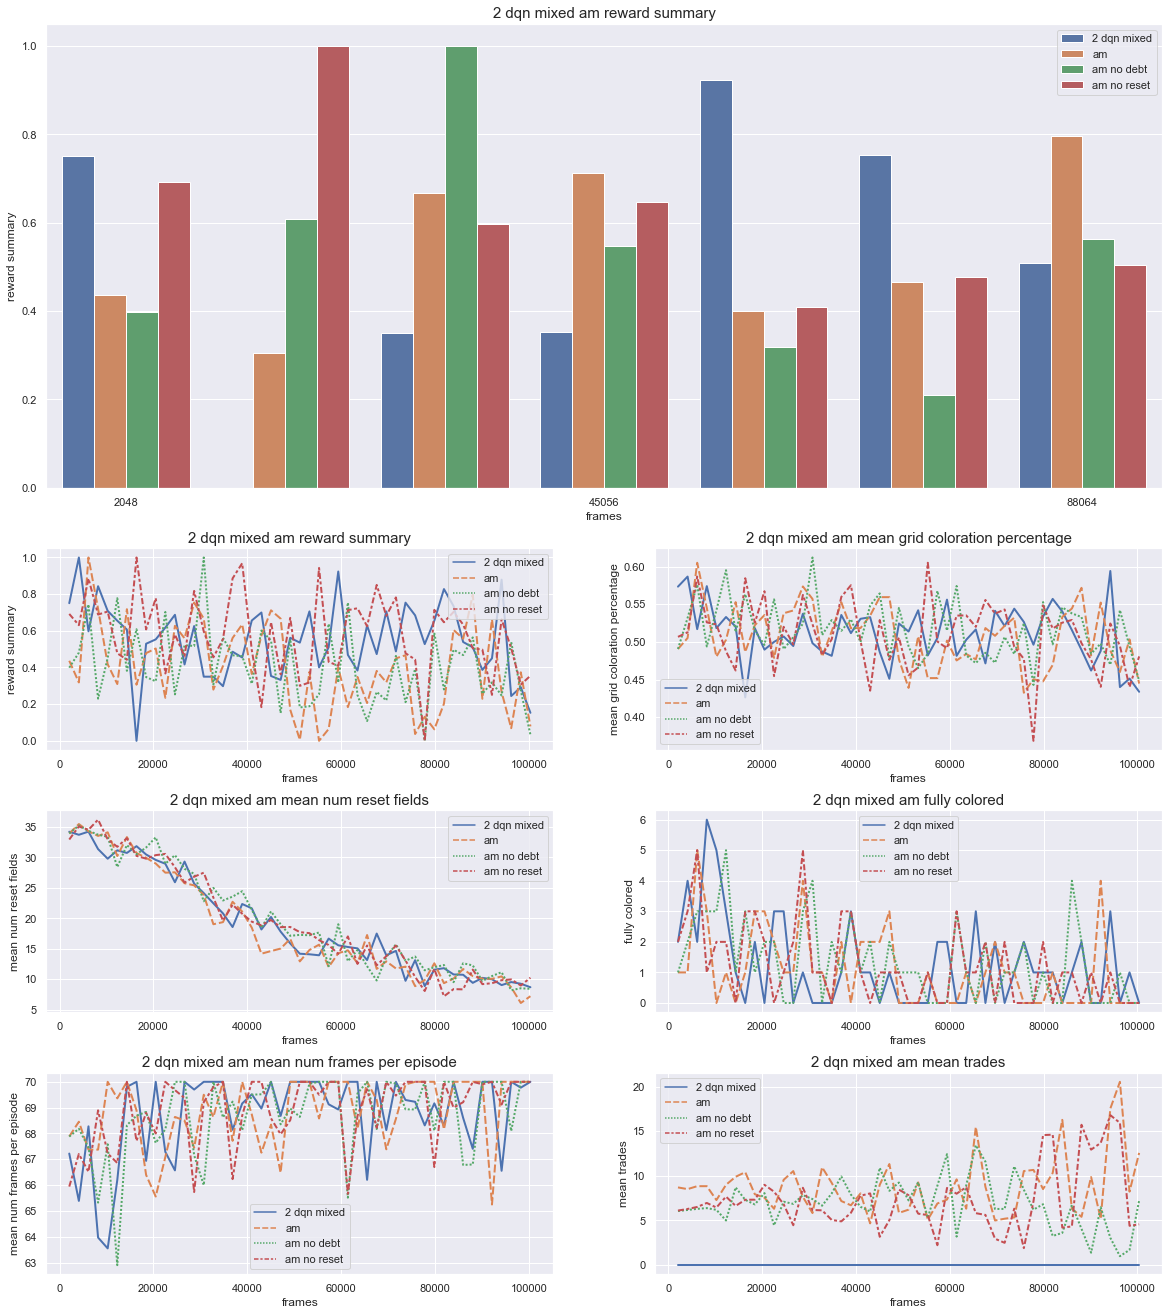

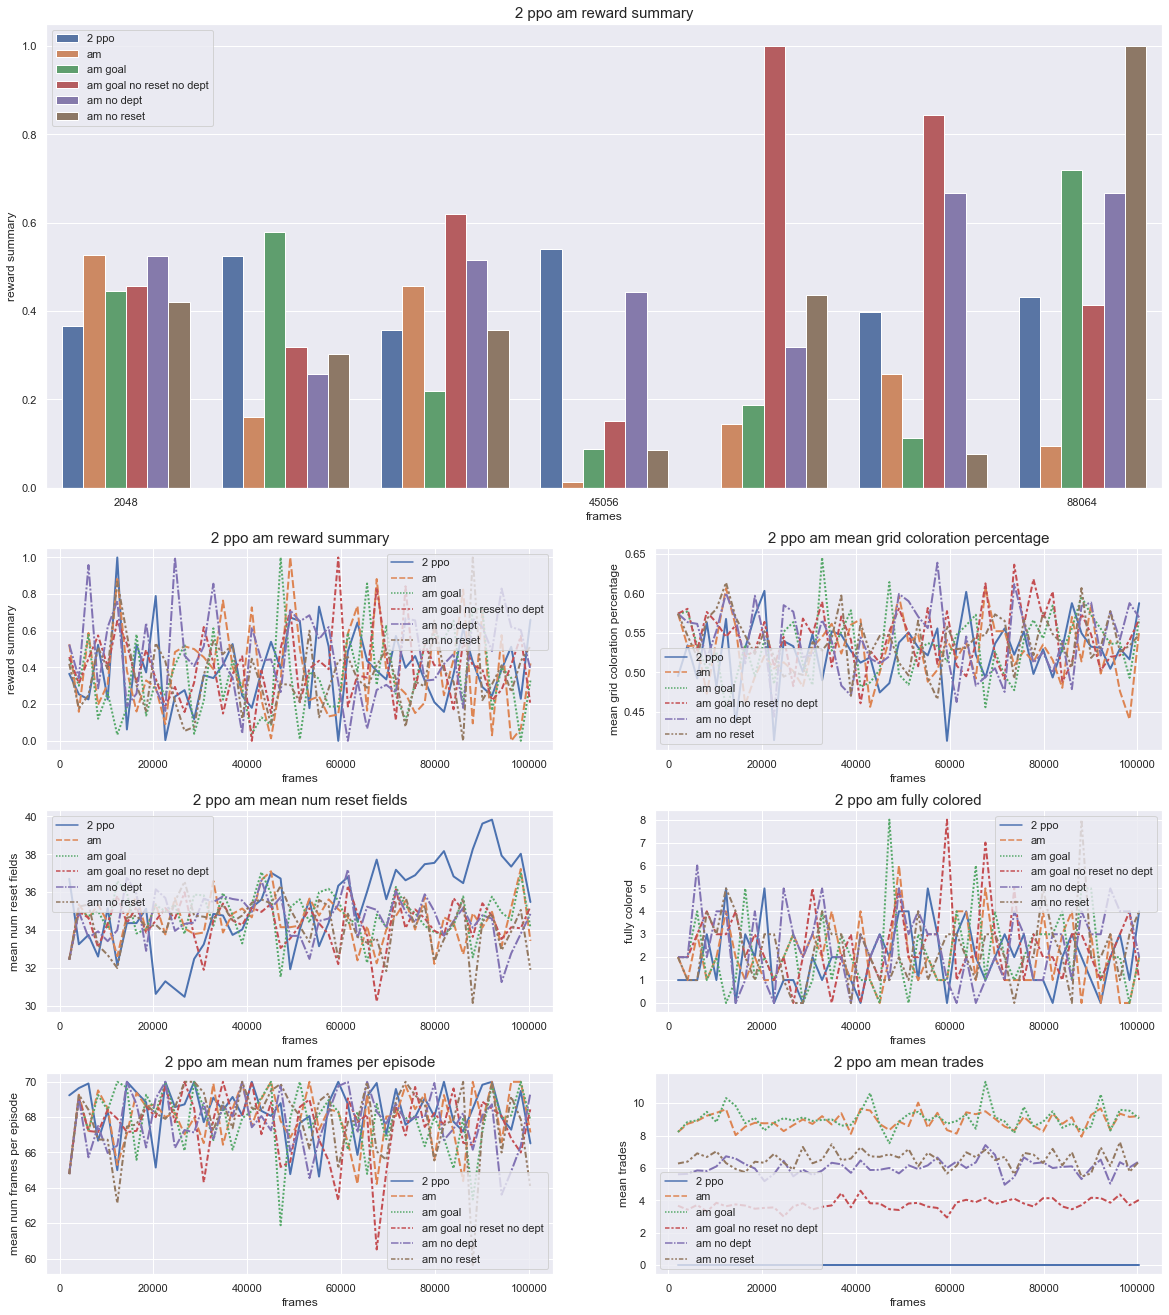

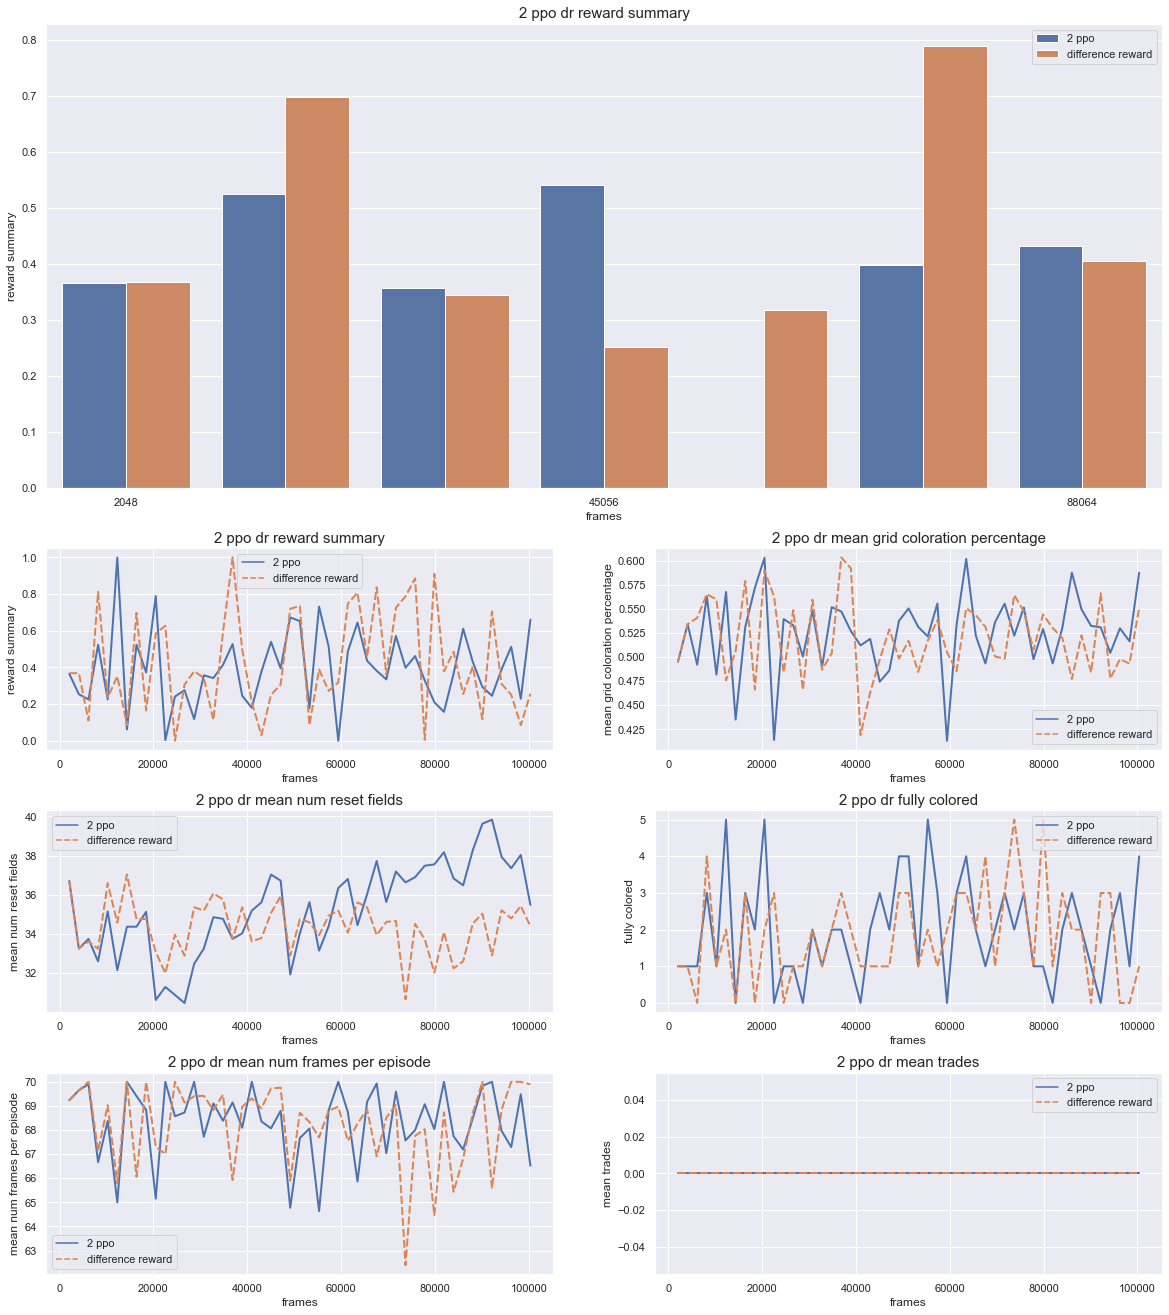

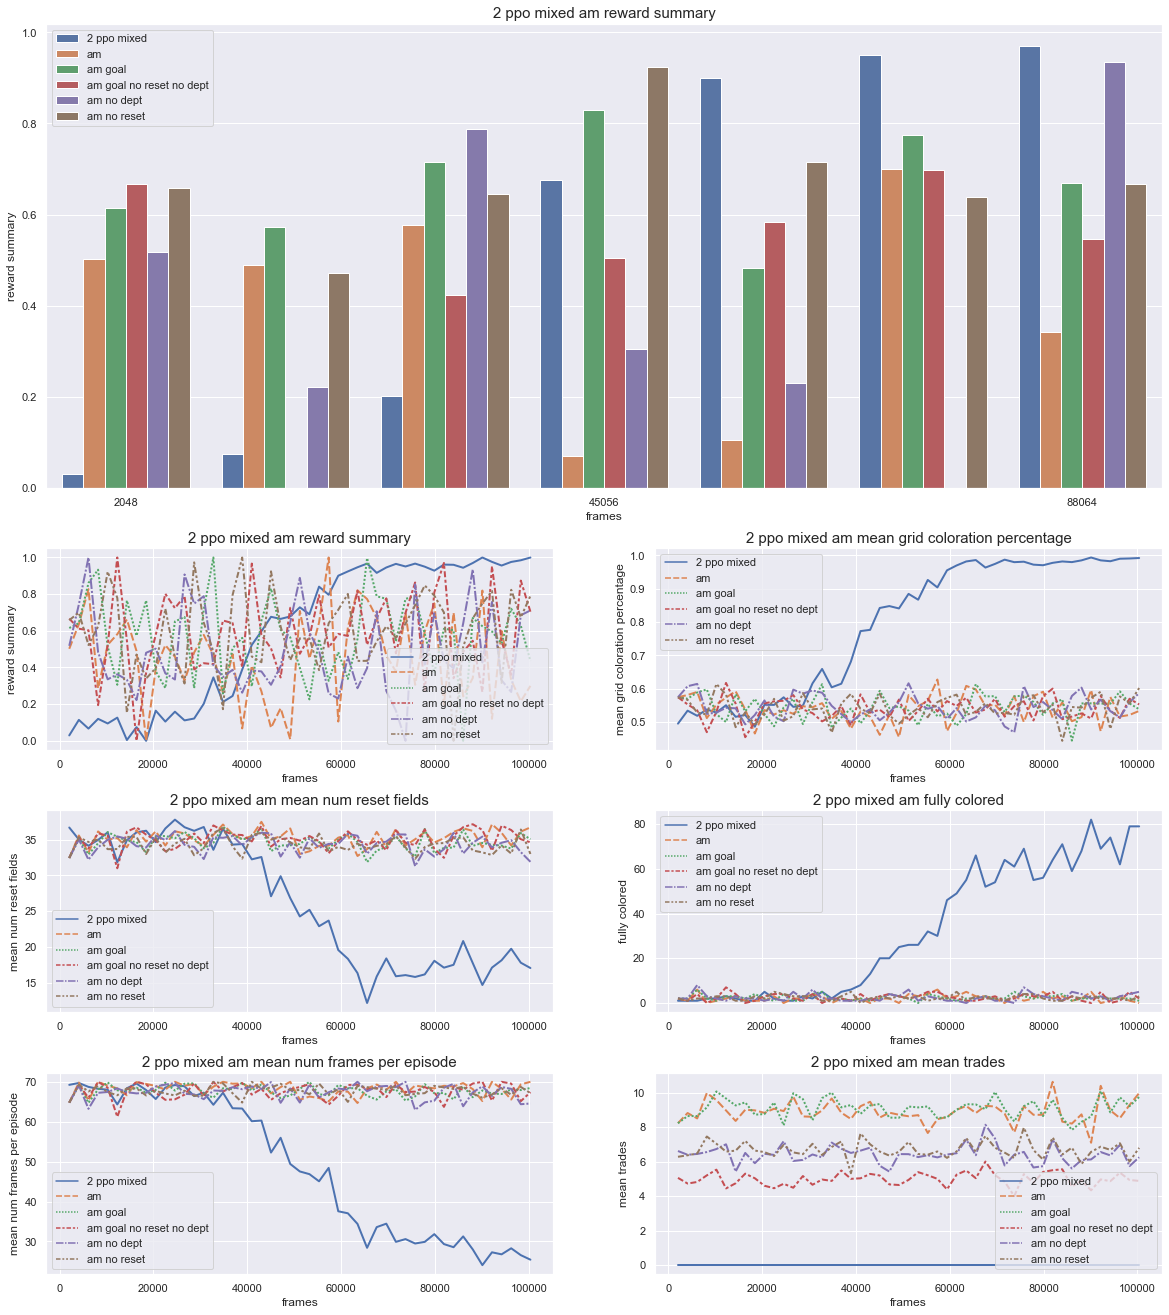

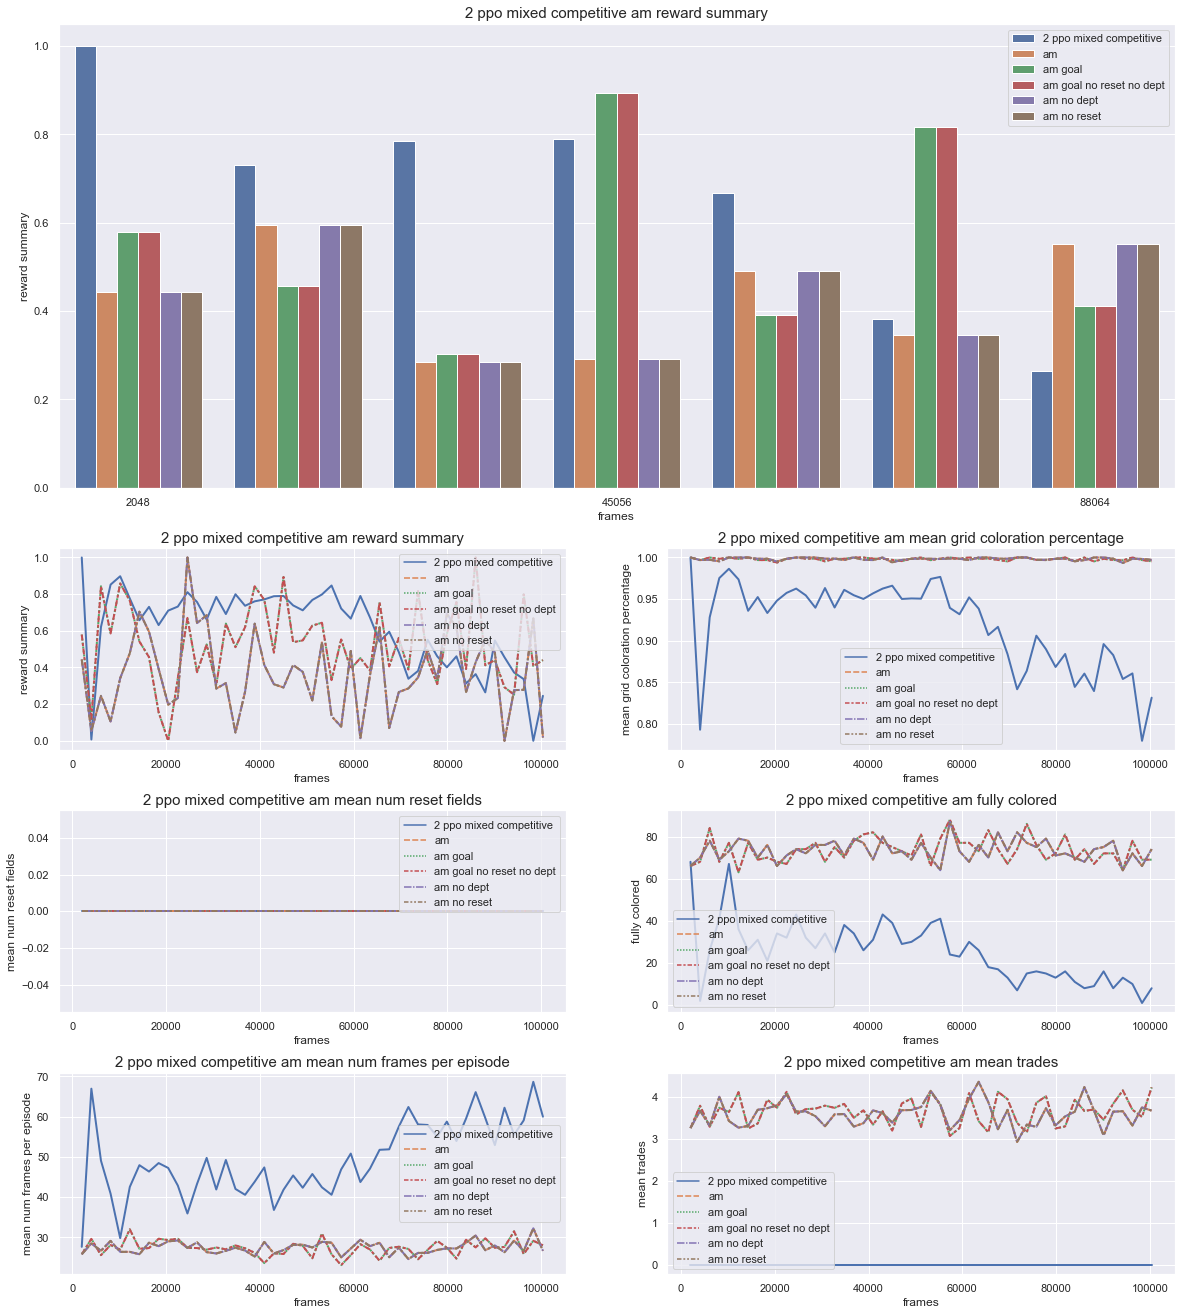

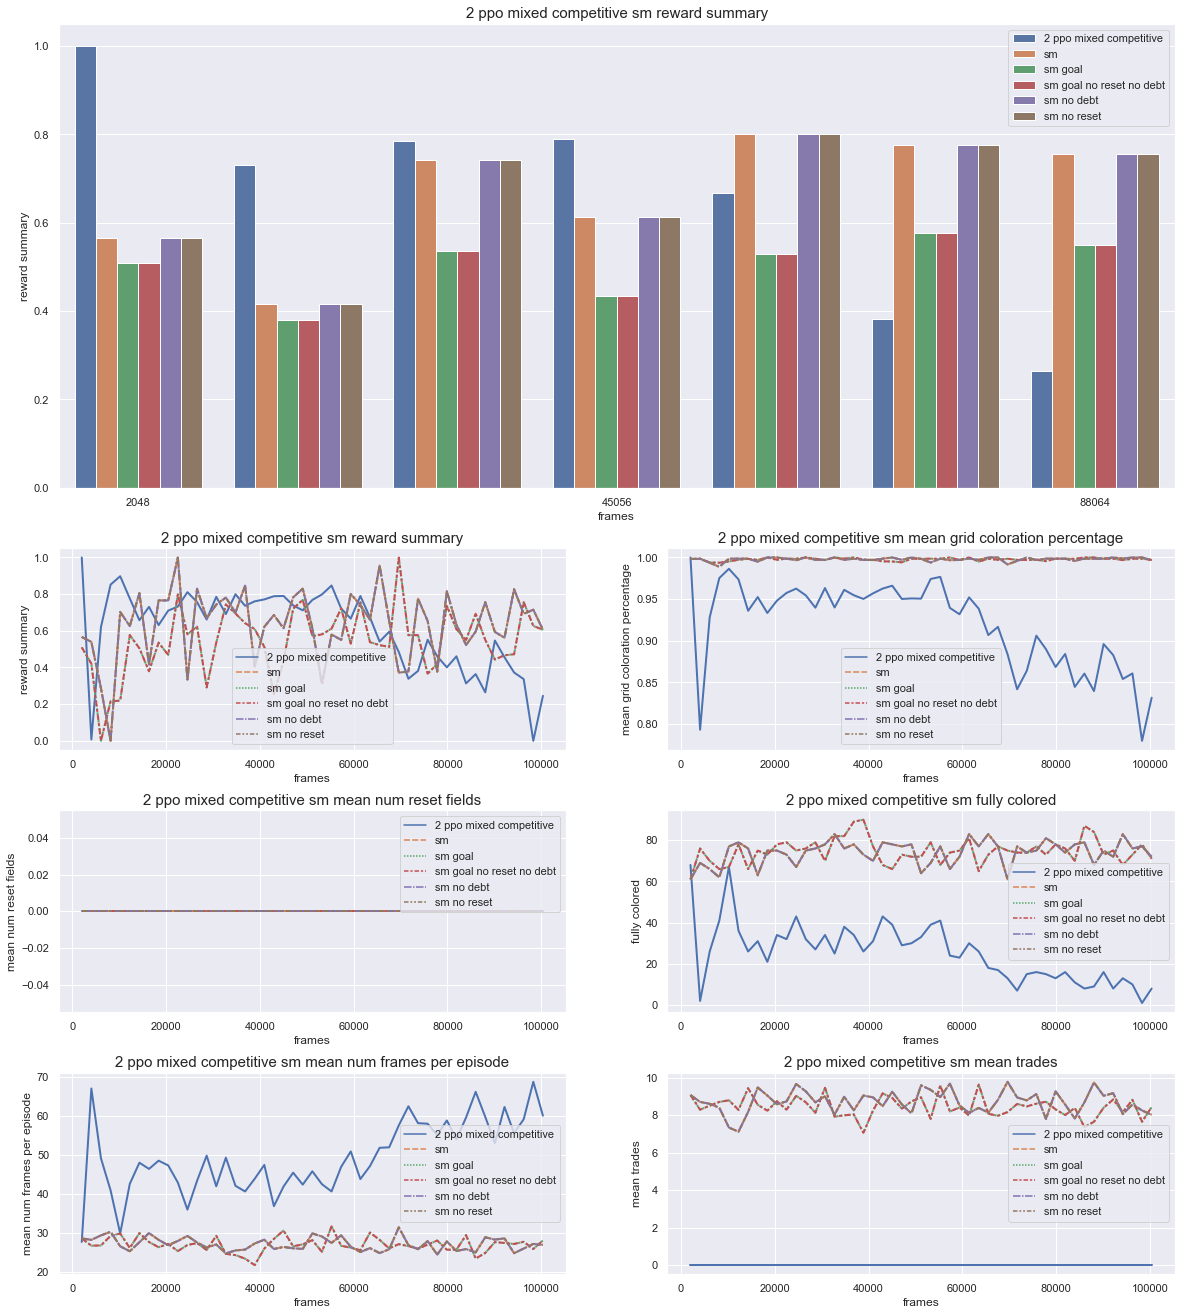

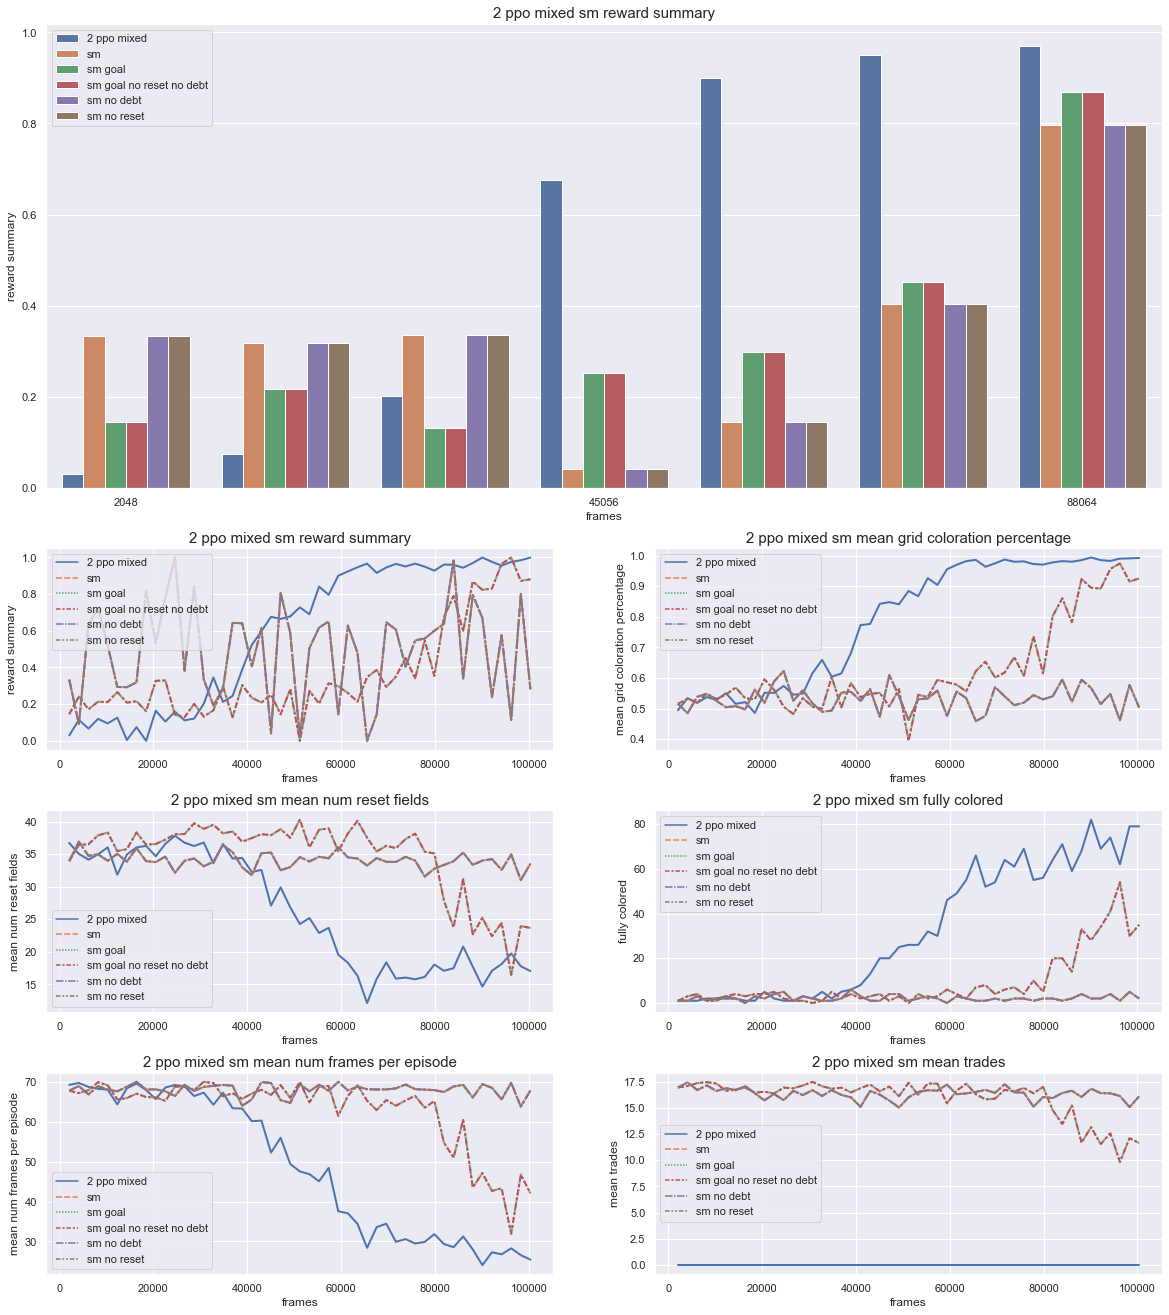

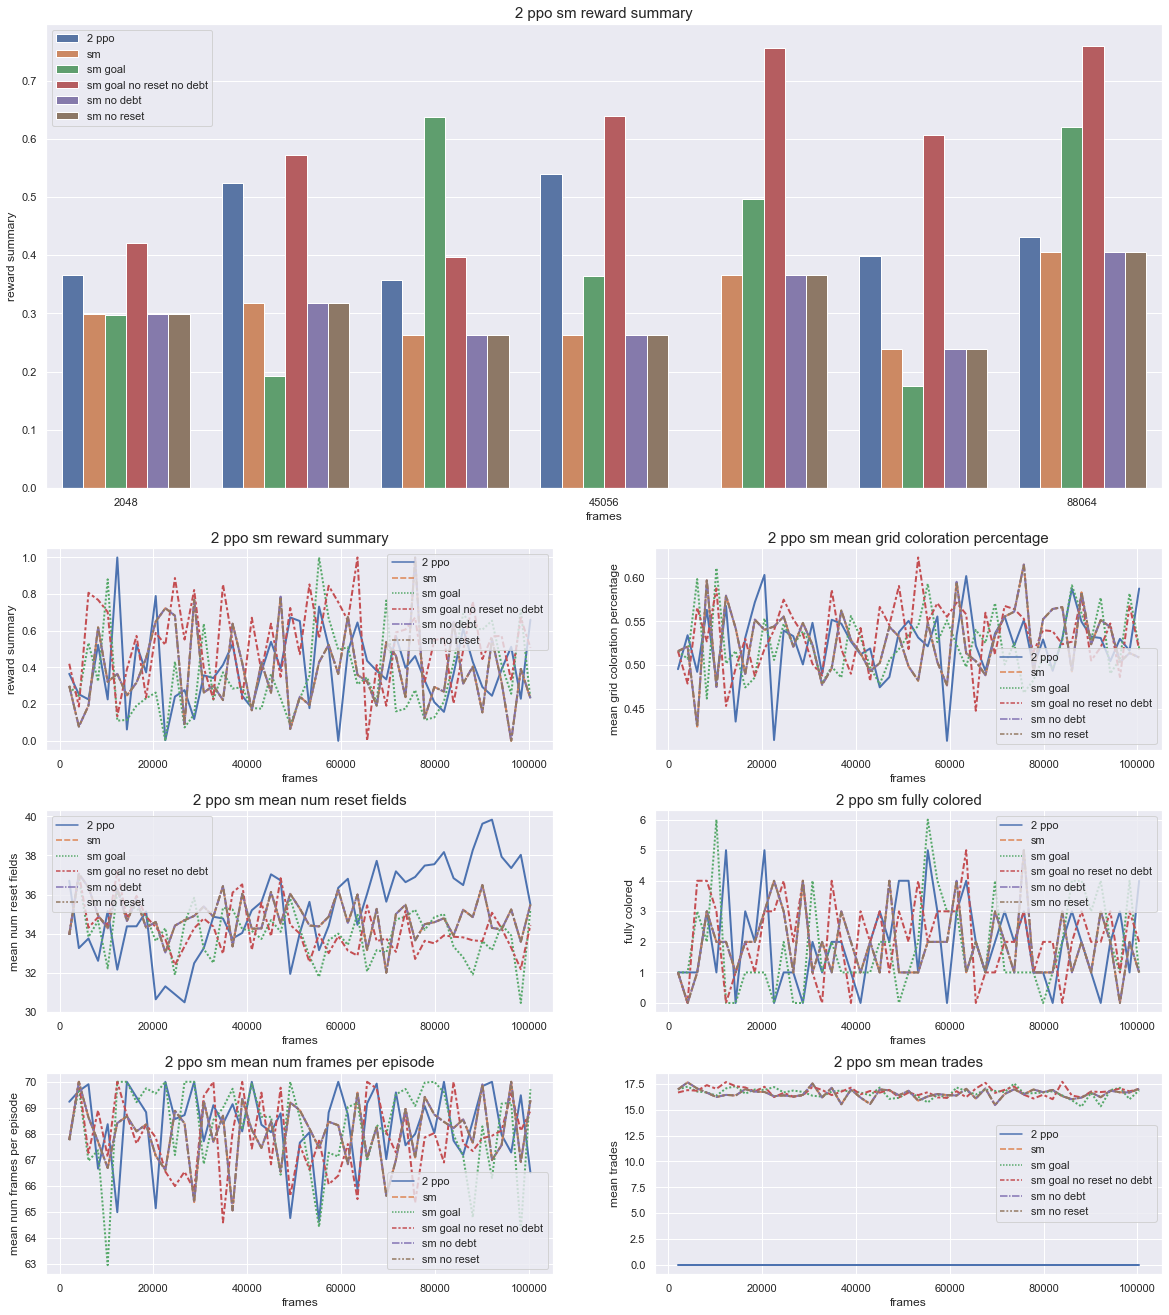

In [140]:

sns.set_theme()
max_col = 2
max_row = 5
col = 0
row = 0

for setting in lf_comparison_settings_dict.keys():
    if row >= max_row or (row == 0 and col == 0): 
        row = 0
        fig = plt.figure(constrained_layout=True, figsize=(20, 23))
        grid = plt.GridSpec(max_row, max_col, hspace=0.3)
        # f, axes = plt.subplots(nrows=max_row, ncols=max_col, figsize=(20, 16))
    title = " ".join(setting.replace("_", "-").split("-"))
    key = [k for k in keys if k in setting][0]
    y_label = " ".join(key.split("_"))
    if "reward" in key:
        gplot = fig.add_subplot(grid[row:2, :])
        g = sns.barplot(
            data=lf_comparison_settings_dict[setting].iloc[::7, :], 
            x="frames", y=key, hue="setting"#, palette="magma"
        ) #, dodge=False
        # g.set_xticklabels(g.get_xticklabels(), rotation=40, ha="right")
        n = 3  # Keeps every 3th label
        [l.set_visible(False) for (i,l) in enumerate(g.xaxis.get_ticklabels()) if i % n != 0]

        # beatify plot legend labels
        _, labels = g.get_legend_handles_labels()
        for index, label in enumerate(labels):
            if containsMarket(label):
                base = label.split("-am")[0] if "-am" in setting else setting.split("-sm")[0]
                new_label = label.split(base)[1]
                new_label = new_label.split(key)[0]
            elif "-dr" in label:
                new_label = "difference reward" #label.split("-dr")[0]+"-dr"
            else:
                new_label = label.split(key)[0] #" ".join(label.split("_")).replace(title+" ", "")
            new_label = " ".join(new_label.split("_"))
            new_label = " ".join(new_label.split("-"))
            labels[index] = new_label.strip()
        g.legend(handles=g.legend_.legendHandles,labels=labels)

        gplot.set_ylabel(y_label)
        gplot.set_title(title, fontsize = 15.0)
        # plt.subplot(grid[row, 0:])
        row += 2
        col = 0
    # else:

    hplot = fig.add_subplot(grid[row, col])
    h = sns.lineplot(data=lf_comparison_settings_dict[setting], legend="brief", x="frames", y=key, hue="setting", style="setting", linewidth=2
        # , palette="magma" #"pastel" | "viridis"
    ) 
    # g.set(ylabel=y_label, title=title)
    
    # beatify plot legend labels
    _, labels = h.get_legend_handles_labels()
    for index, label in enumerate(labels):
        if containsMarket(label):
            base = label.split("-am")[0] if "-am" in setting else setting.split("-sm")[0]
            new_label = label.split(base)[1]
            new_label = new_label.split(key)[0]
        elif "-dr" in label:
            new_label = "difference reward" #label.split("-dr")[0]+"-dr"
        else:
            new_label = label.split(key)[0] #" ".join(label.split("_")).replace(title+" ", "")
        new_label = " ".join(new_label.split("_"))
        new_label = " ".join(new_label.split("-"))
        labels[index] = new_label.strip()
    h.legend(handles=h.legend_.legendHandles,labels=labels)
    
    hplot.set_ylabel(y_label)
    hplot.set_title(title, fontsize = 15.0)

    col += 1
    if col == max_col:
        row += 1
        col = 0

    # f.tight_layout()

In [141]:
def beautify_legend(plot_name, setting, key):
    # beatify plot legend labels
    _, labels = plot_name.get_legend_handles_labels()
    for index, label in enumerate(labels):
        if containsMarket(label):
            base = label.split("-am")[0] if "-am" in setting else setting.split("-sm")[0]
            new_label = label.split(base)[1]
            new_label = new_label.split(key)[0]
        elif "-dr" in label:
            new_label = "difference reward" #label.split("-dr")[0]+"-dr"
        else:
            new_label = label.split(key)[0] #" ".join(label.split("_")).replace(title+" ", "")
        new_label = " ".join(new_label.split("_"))
        new_label = " ".join(new_label.split("-"))
        labels[index] = new_label.strip()
    plot_name.legend(handles=plot_name.legend_.legendHandles,labels=labels)

def plot_comparisons(plot_list):
    sns.set_theme()
    max_col = 2
    max_row = 5
    col = 0
    row = 0

    for setting in plot_list:
        if row >= max_row or (row == 0 and col == 0): 
            row = 0
            # f, axes = plt.subplots(nrows=max_row, ncols=max_col, figsize=(20, 16)) #, sharex=True
            # plt.subplots_adjust(hspace=0.3)
            fig = plt.figure(constrained_layout=True, figsize=(20, 23))
            grid = plt.GridSpec(max_row, max_col, hspace=0.3)
        title = " ".join(setting.replace("_", "-").split("-"))
        key = [k for k in keys if k in setting][0]
        y_label = " ".join(key.split("_"))
        if "reward" in key:
            gplot = fig.add_subplot(grid[row:2, :])
            g = sns.barplot(
                data=lf_comparison_settings_dict[setting].iloc[::7, :], 
                x="frames", y=key, hue="setting")
            n = 3  # Keeps every 3th label
            [l.set_visible(False) for (i,l) in enumerate(g.xaxis.get_ticklabels()) if i % n != 0]

            # beatify plot legend labels
            beautify_legend(g, setting, key)

            gplot.set_ylabel(y_label)
            gplot.set_title(title, fontsize = 15.0)
            row += 2
            col = 0

        hplot = fig.add_subplot(grid[row, col])
        h = sns.lineplot(data=lf_comparison_settings_dict[setting], legend="brief", x="frames", y=key, hue="setting", style="setting", linewidth=2
            # , palette="magma" #"pastel" | "viridis"
        )
        
        # beatify plot legend labels
        beautify_legend(h, setting, key)
        
        hplot.set_ylabel(y_label)
        hplot.set_title(title, fontsize = 15.0)

        col += 1
        if col == max_col:
            row += 1
            col = 0


# DQN 

## DQN Lerning of one agent

C:\Users\Zarah\.virtualenvs\Coloring_with_CAP-xNNGJax5\lib\site-packages\IPython\core\pylabtools.py:137: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


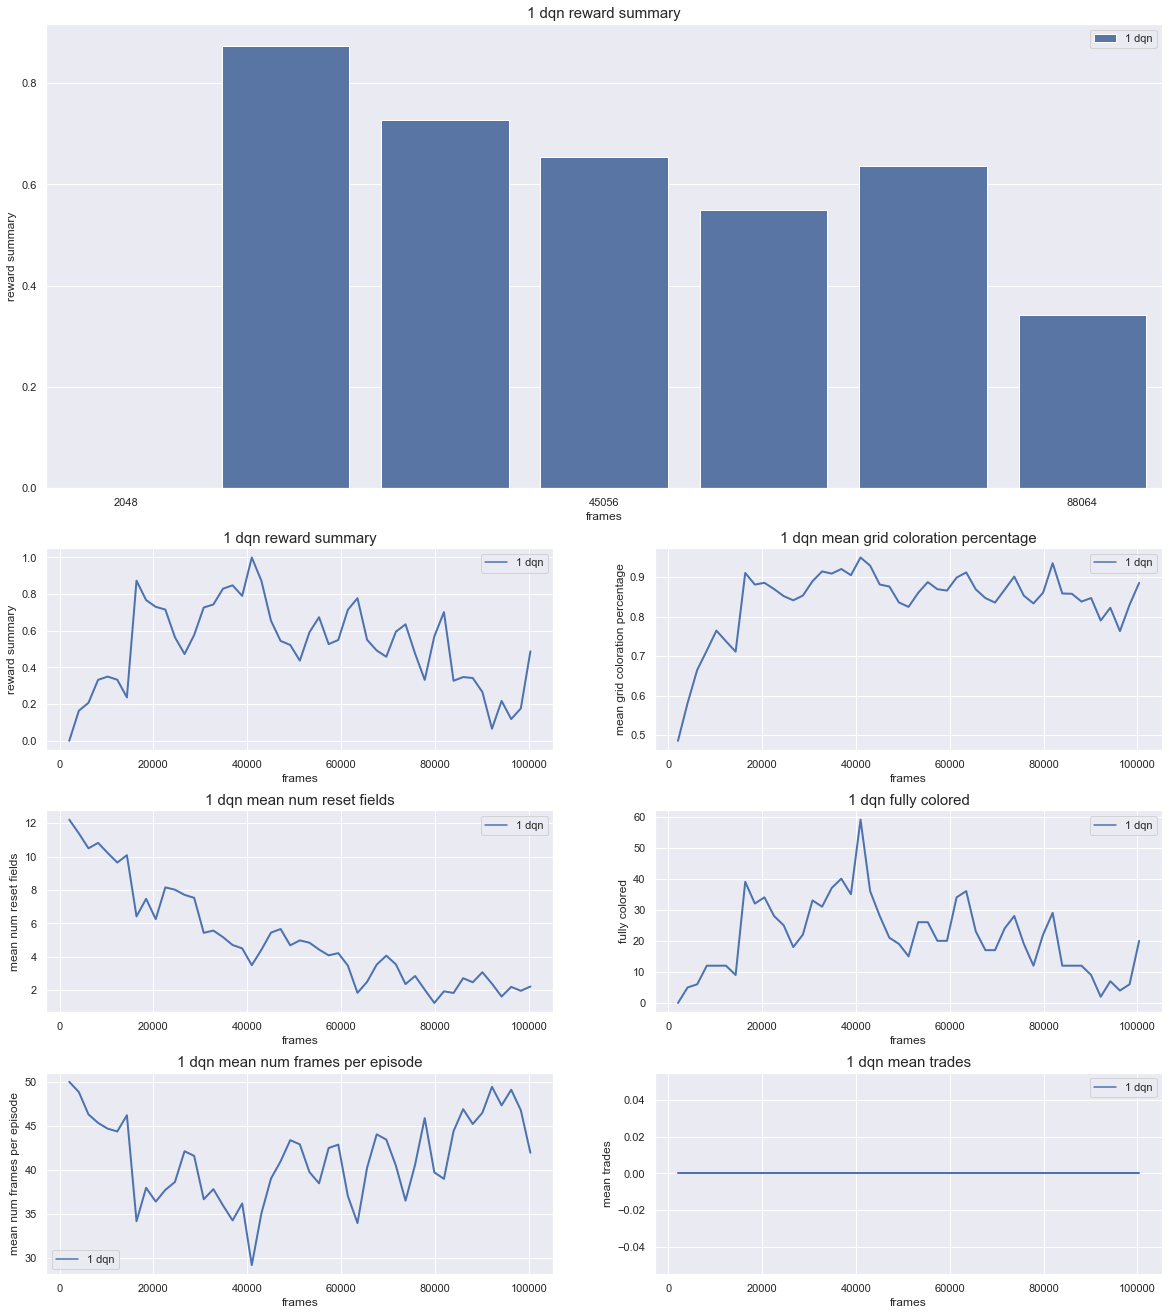

In [142]:
# DQN Algorithm with one agent
plot_comparisons(detailed_plots[0])

## DQN Difference Reward Comparisons
Comparing the difference reward algorithm of 2 agents working in cooperation versus the default cooperation mode of 2 dqn agents 

C:\Users\Zarah\.virtualenvs\Coloring_with_CAP-xNNGJax5\lib\site-packages\IPython\core\pylabtools.py:137: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


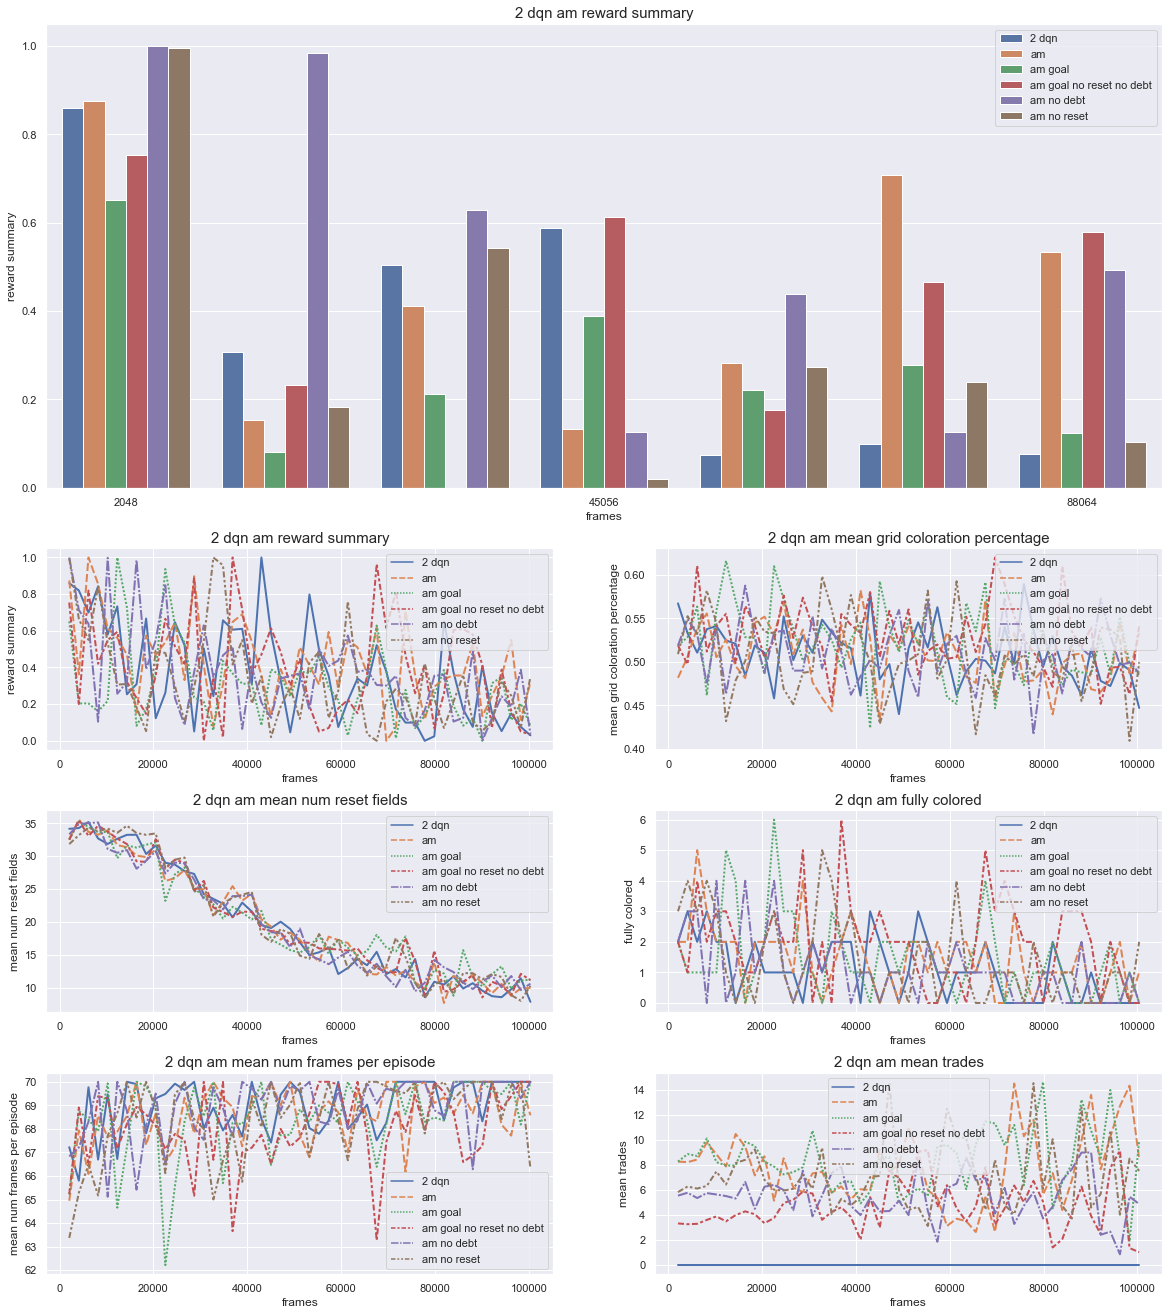

In [143]:
plot_comparisons(detailed_plots[2])

Some thoughts:
- rewards:
    - no constant value wich means no learning 
- coloration percentages:
    - both mean percentages are rather low (at around 50%), which also hint to no learning improvements
- reset fields:
    - agents of both settings learn to reset less fields, possibly executing more waiting actions since rewards are not improving
- fully colored:
    - both are also quite low, no constant increase that would indicate learning
    - here it is visible however that dr setting lead to more goals!
- number of frames per episode:
    - since difference reward achieves more goals, the amount of steps are lower in some points
    - oveall the numbers are very high with the lowest being 63 -> 63 steps to color a 5x5 grid with a walkable are of 3x3 = 9 cells is quite high -> probably achieved by chance!
    - due to the high step amount the assumption is confirmed that a lot of waiting actions are executed

## DQN Shareholder Market Comparisons
### DQN Shareholder Market Cooperative Mode

C:\Users\Zarah\.virtualenvs\Coloring_with_CAP-xNNGJax5\lib\site-packages\IPython\core\pylabtools.py:137: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


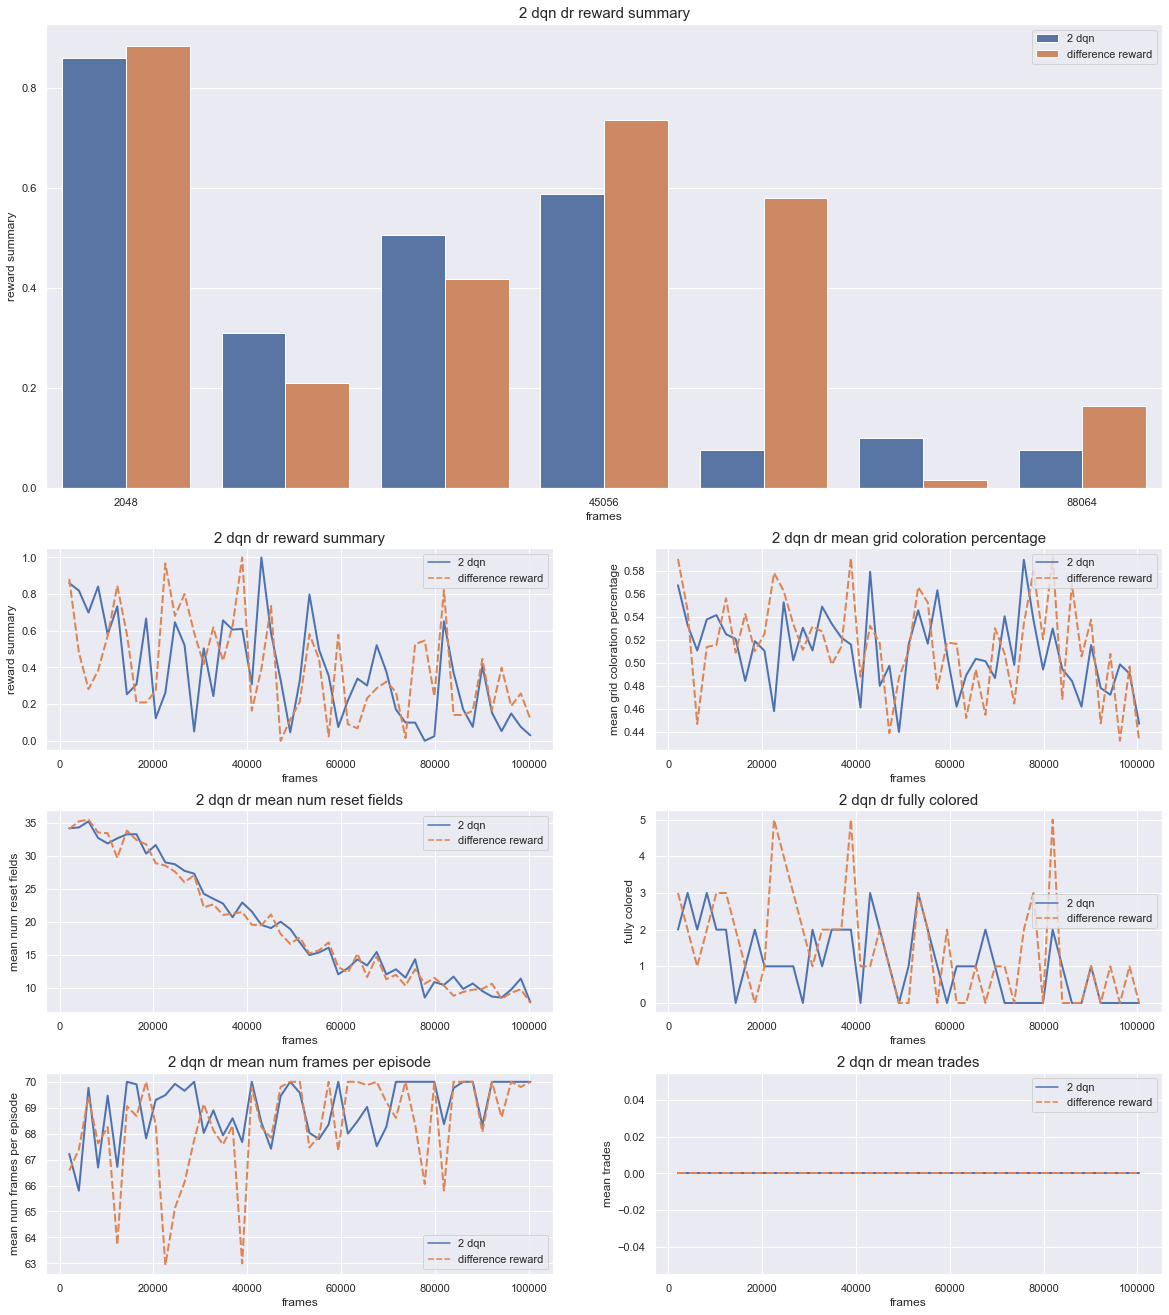

In [144]:
plot_comparisons(detailed_plots[3])

Some thoughts:
- rewards:
    - no constant value/increase wich means no learning takes place 
- coloration percentages:
    - mean percentages are rather low (at around 50%), which also hint to no learning improvements
- reset fields:
    - agents learn to reset less fields, possibly executing more waiting actions since rewards are not improving
- fully colored:
    - quite little, no constant increase that would indicate learning
- number of frames per episode:
    - numbers are very high with the lowest being 62 -> 62 steps to color a 5x5 grid with a walkable are of 3x3 = 9 cells is quite high -> probably achieved by chance!
    - due to the high step amount the assumption is confirmed that a lot of waiting actions are executed

# PPO

## PPO Learning of one agent

C:\Users\Zarah\.virtualenvs\Coloring_with_CAP-xNNGJax5\lib\site-packages\IPython\core\pylabtools.py:137: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


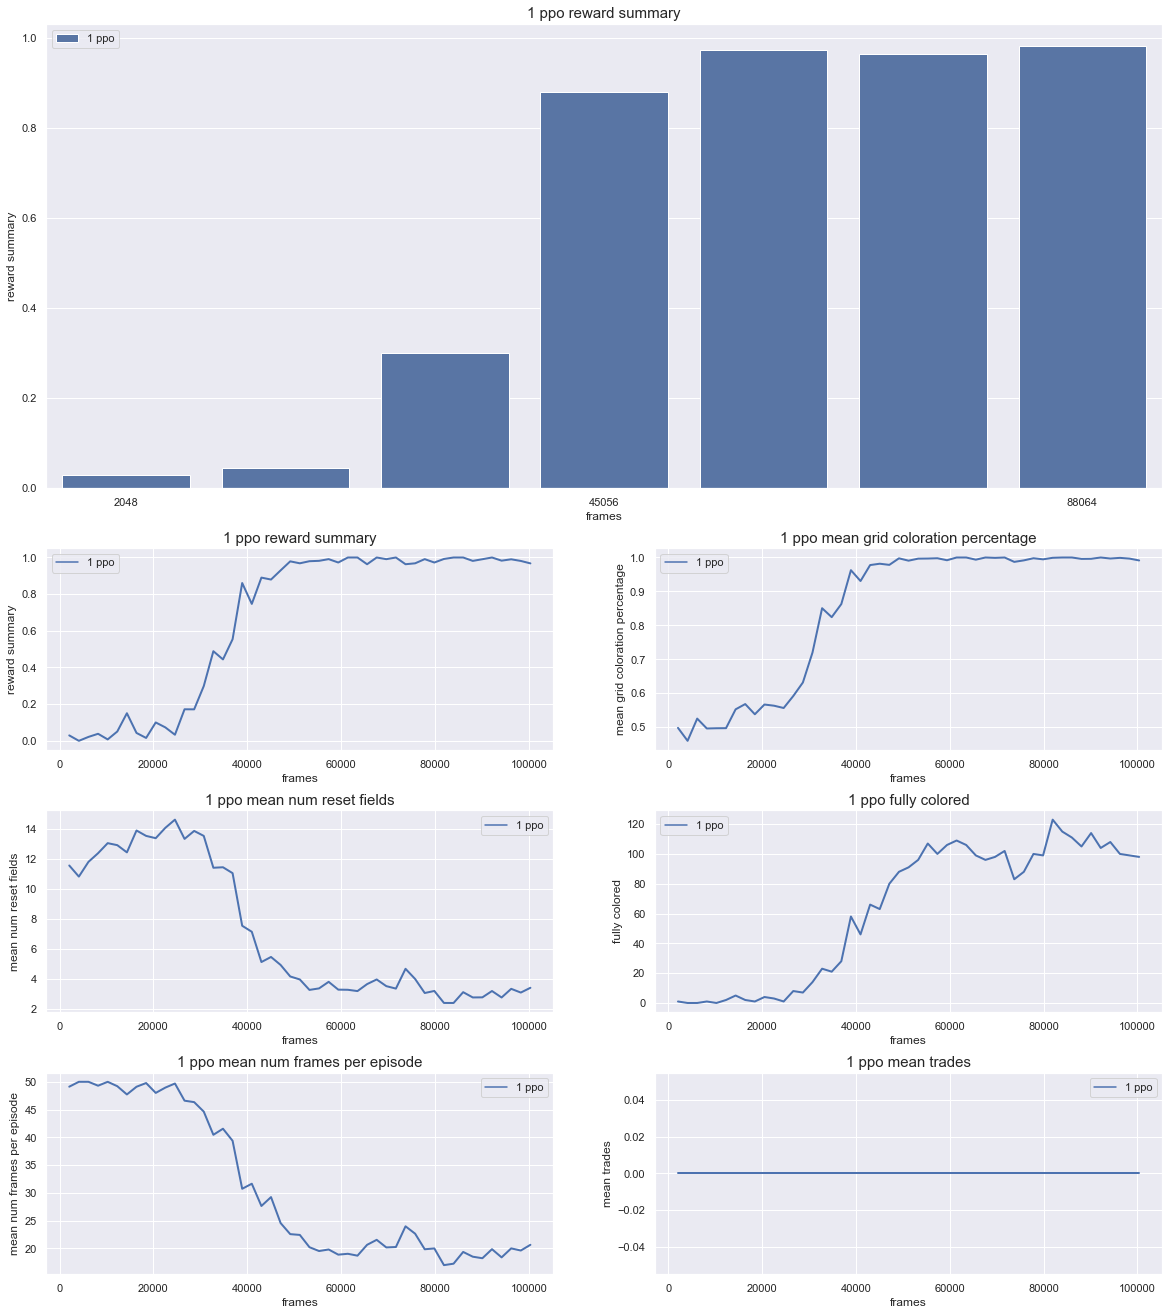

In [145]:
plot_comparisons(detailed_plots[1])

## PPO Difference Reward Comparisons
Comparing the difference reward algorithm of 2 agents working in cooperation versus the default cooperation mode of 2 ppo agents 

C:\Users\Zarah\.virtualenvs\Coloring_with_CAP-xNNGJax5\lib\site-packages\IPython\core\pylabtools.py:137: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


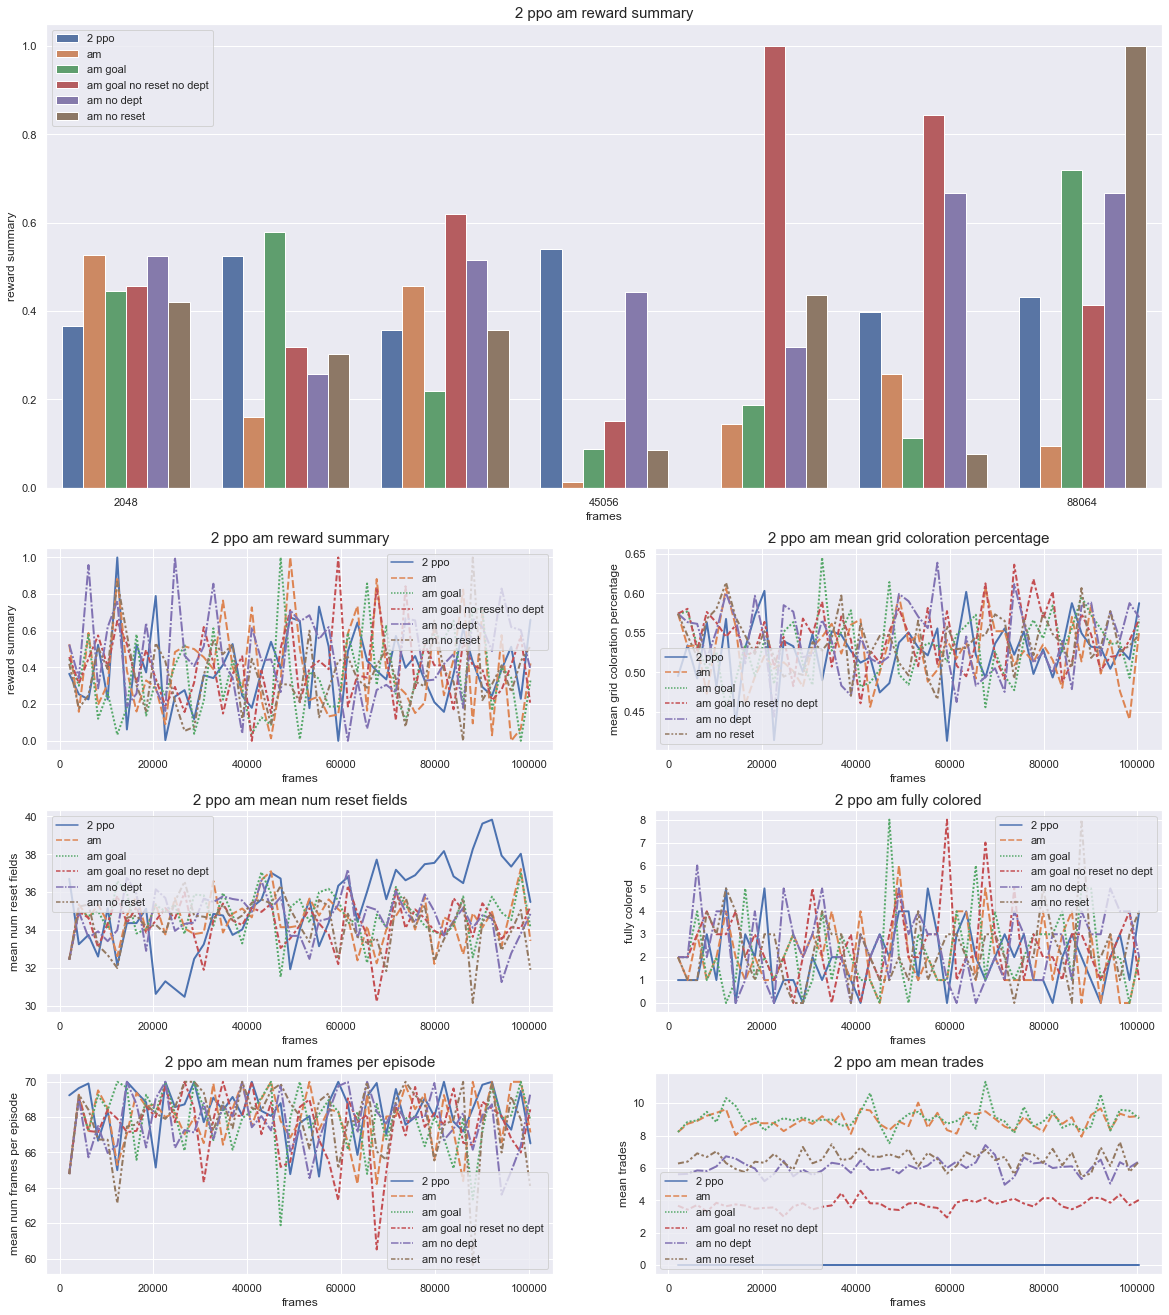

In [146]:
plot_comparisons(detailed_plots[5])

Some thoughts:
- rewards:
    - no constant value wich means no learning 
- coloration percentages:
    - both mean percentages are rather low (at around 50%), which also hint to no learning improvements
    - dr line shows fewer outliers
- reset fields:
    - agents of both settings reset a lot of fields
    - dr line shows less resets however
- fully colored:
    - both are also quite low, no constant increase that would indicate learning
    - here it is visible however that the default mode leads to more goals!
- number of frames per episode:
    - oveall the numbers are very high with the lowest being around 63 -> 63 steps to color a 5x5 grid with a walkable area of 3x3 = 9 cells is quite high -> probably achieved by chance!
    - due to the high step amount the assumption is confirmed that a lot of waiting actions are executed

## PPO Action Market Comparisons
### PPO Action Market Cooperative Mode

C:\Users\Zarah\.virtualenvs\Coloring_with_CAP-xNNGJax5\lib\site-packages\IPython\core\pylabtools.py:137: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


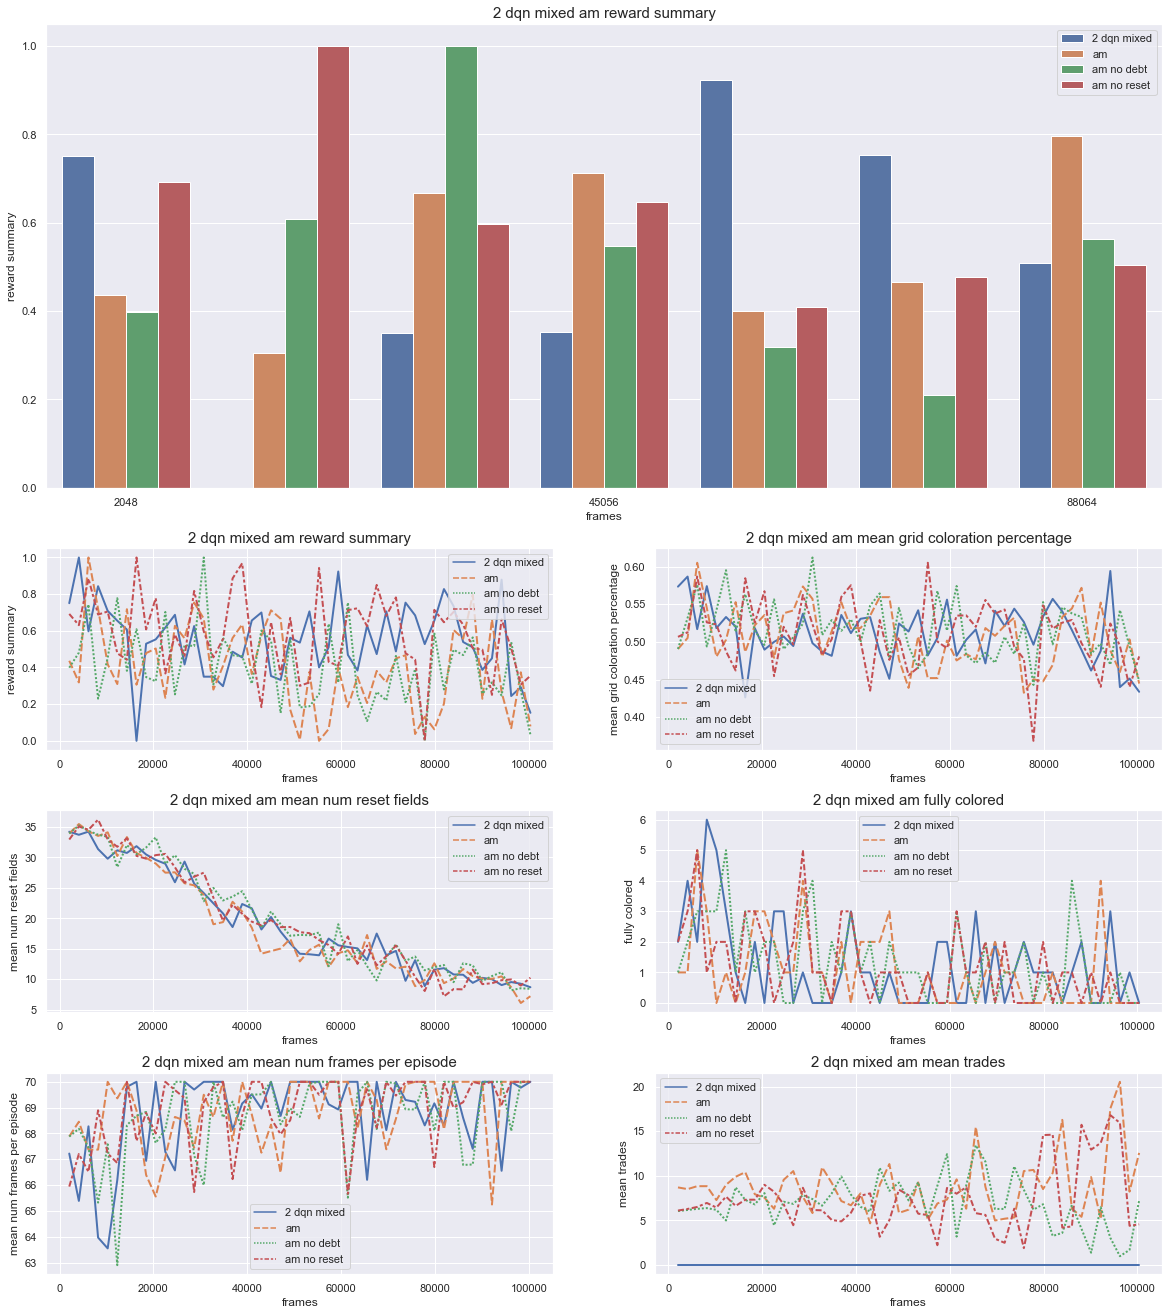

In [147]:
plot_comparisons(detailed_plots[4])

Some thoughts:
- rewards:
    - no constant value/increase wich means no learning takes place 
- coloration percentages:
    - mean percentages are rather low (at around 50%), which also hint to no learning improvements
- reset fields:
    - agents learn without am reset less fields
- fully colored:
    - quite little, no constant increase that would indicate learning
- number of frames per episode:
    - numbers are very high with the lowest being 62 -> 62 steps to color a 5x5 grid with a walkable are of 3x3 = 9 cells is quite high -> probably achieved by chance!
    - due to the high step amount the assumption is confirmed that a lot of waiting actions are executed

### PPO Action Market Mixed-Motive Mode

C:\Users\Zarah\.virtualenvs\Coloring_with_CAP-xNNGJax5\lib\site-packages\IPython\core\pylabtools.py:137: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


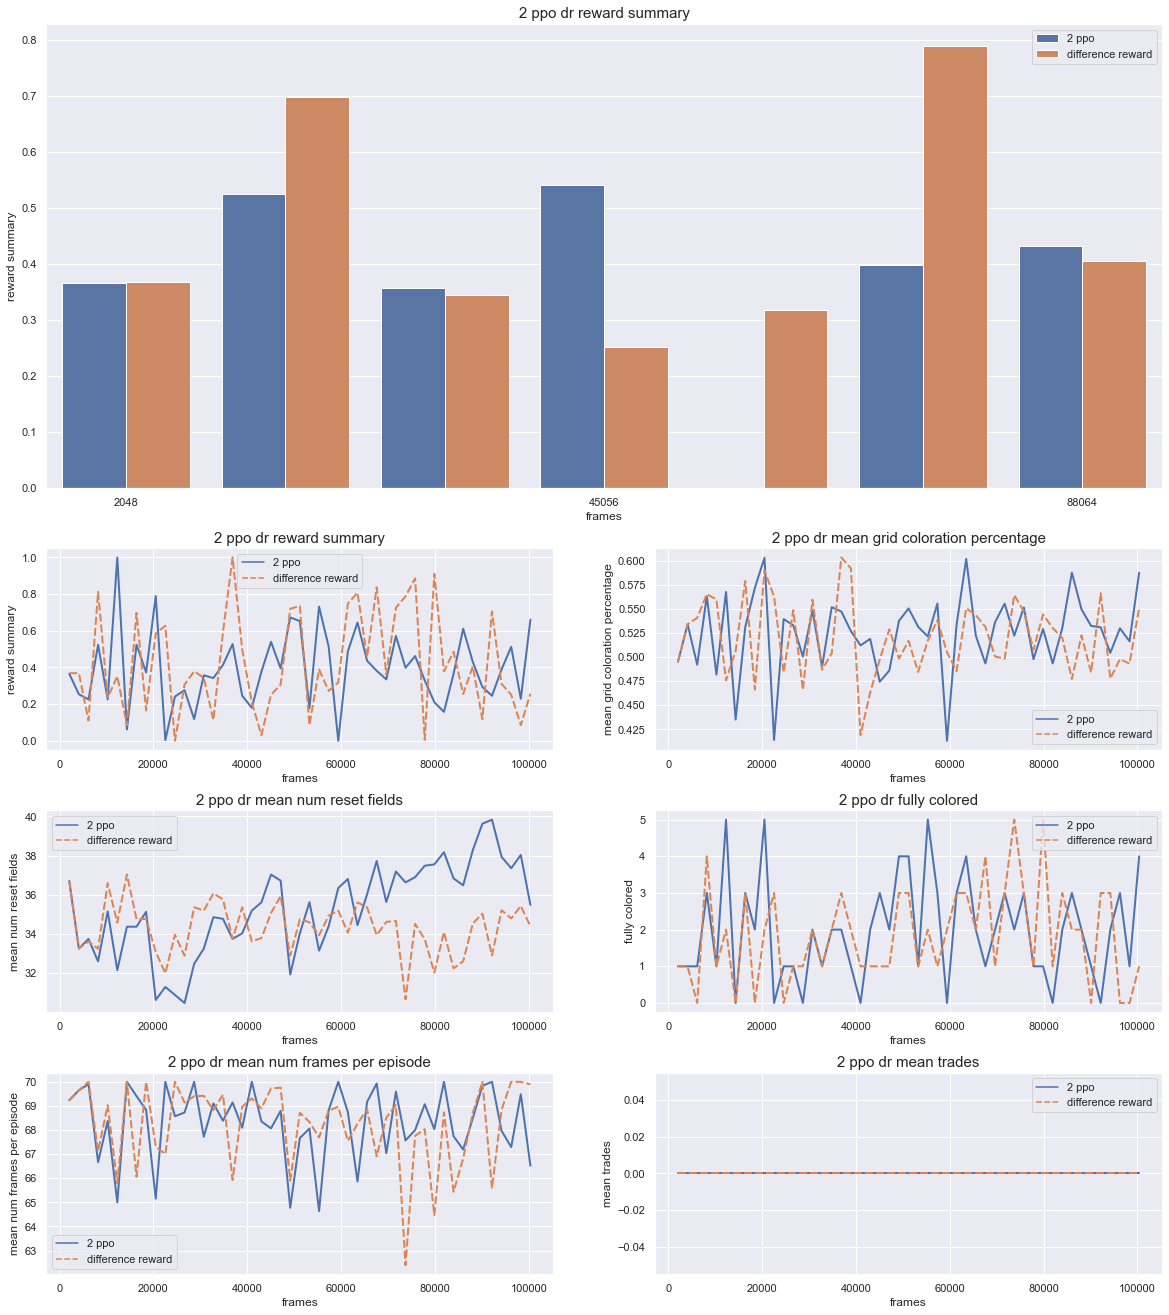

In [148]:
plot_comparisons(detailed_plots[6])